In [1]:
# a couple plotting conveniences...
%matplotlib inline
from matplotlib import pyplot as plt

# Exploration:  Medication code normalization

This Jupyter notebook contains informal notes regarding the characterization, normalization, and code resolution of medications in the HSSC Clinical Data Warehouse (CDW).  It is not a distilled description or set of instructions but rather reflects the exploratory nature of a process with no pre-planned path but rather a general *direction* toward *normalization* of codes, of units, of forms, etc.

Any path will require access to the CDW and utilization of the RxNorm REST services, so I'll prepare some functions and libraries before getting started.

## Prepare RxNorm functions

In [2]:
# these are expected to be in the current working directory
from throttle import *   # throttle decorator to limit frequency of wrapped function calls
from epana.tabular import *    # convenience functions for tabular data stats

# other imports
import pandas as pd
import functools
from pprint import pprint
from collections import Counter
import pickle
import csv
import requests


#Test throttle decorator
F = 20
N = 20
F_throttled = measure_throttle(n=N, per_sec=F)
res_str = 'Throttle Test:\t%%s (%.3f calls per second)'%F_throttled
if F_throttled < F and F_throttled > 0.9*F:
    print(res_str%'PASS')
else:
    print(res_str%'FAIL')


def cached(func):
    func.cache = {}
    try:
        func.cache = pickle.load(open('%s.cache.pickle'%func.__name__, 'rb'))
    except FileNotFoundError:
        pass

    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        key = (args, frozenset(kwargs.items()))
        try:
            return func.cache[key]
        except KeyError:
            func.cache[key] = result = func(*args, **kwargs)
            return result   
    return wrapper


#@throttle(per_sec=20)
@cached
def rxnorm_req(resource, **kwargs):
    is_json = True
    if 'rxnorm_base' not in kwargs:
         kwargs['rxnorm_base'] = 'https://rxnav.nlm.nih.gov/REST/'
    if 'json' in kwargs:
        is_json = kwargs['json']
    if is_json:
        resource += '.json'
    
    attrs = ['%s=%s'%(attr,val) for (attr,val) in
             kwargs.items() if attr != 'rxnorm_base']
    
    req = kwargs['rxnorm_base'] + resource + '?%s'%('&'.join(attrs))
    
    resp = requests.get(req)
    return resp.json() if is_json else resp


def coerce_rxcui(rxcui):
    json = rxnorm_req('rxcui/%s/status'%rxcui)
    status = json['rxcuiStatus']['status']
    
    if status in ('Retired', 'Unknown', 'Alien'):
        #warning('Cannot coerce! status = %s'%status)
        return None
    
    retval = json['rxcuiStatus']['minConceptGroup']['minConcept'][0]['rxcui']
    return retval


def get_status(rxcui):
    json = rxnorm_req('rxcui/%s/status'%rxcui)
    status = json['rxcuiStatus']['status']
    return status


def get_TTY(rxcui):
    json = rxnorm_req('rxcui/%s/property'%rxcui, propName='TTY')
    cgroup = json['propConceptGroup']
    if cgroup is None:
        return ''
    return cgroup['propConcept'][0]['propValue']


def get_props(rxcui, skip_coerce=False):
    json = rxnorm_req('rxcui/%s/properties'%rxcui)
    key = 'properties'
    props = None
    if json is None:
        if skip_coerce == False:
            rxcui_new = coerce_rxcui(rxcui)
            if rxcui_new is not None:
                props = get_props(coerce_rxcui(rxcui),
                                  skip_coerce=True)
    else:
        props = json[key]
    
    return props


def get_ins(rxcui):
    json = rxnorm_req('rxcui/%s/related'%rxcui, tty='IN')
    try:
        retval = [(y['rxcui'], y['name']) for y in
                  [x['conceptProperties'] for x in
                   json['relatedGroup']['conceptGroup']][0]]
    except KeyError as e:
        #warning('missing key %s'%e)
        return []
    return retval


def get_scd(rxcui):
    # https://rxnav.nlm.nih.gov/REST/rxcui/174742/related?tty=SBD+SBDF    
    json = rxnorm_req('rxcui/%s/related'%rxcui, tty='SCD')
    try:
        retval = [(y['rxcui'], y['name']) for y in
                  [x['conceptProperties'] for x in
                   json['relatedGroup']['conceptGroup']][0]]
    except KeyError as e:
        #warning('missing key %s'%e)
        return []
    return retval


def get_rxcui_from_ndc(ndc):
    json = rxnorm_req('rxcui', idtype='NDC', id=ndc)
    try:
        return json['idGroup']['rxnormId'][0]
    except KeyError as e:
        #warning('missing key %s'%e)
        return None

if rxnorm_req(resource='', json=False).status_code == 200:
    print('RxNorm REST Test:\tSUCCESS (status_code 200)')
else:
    print('RxNorm REST Test:\tFAILED')
    

def get_props_df(code):
    '''Wrapper of rxnorm get_props function adapted to work with DataFrame.apply.
    Argument "code" is expected to be the order or admin "med_code," which is an
    rxcui in CDW.  If the code exists, this function checks for RxNorm properties.
    '''
    props = None
    pnames = ['name', 'rxcui', 'synonym', 'tty']
    cnames = ['rxname', 'rxcui', 'rxsyn', 'rxtty']
    retval = None
    if code is not None and len(code)>0:
        props = get_props(code)
    if props is None:
        retval = {cname:None for cname in cnames}
        retval['mo_code'] = code
    else:
        retval = {cname:props[pname] for (cname,pname) in zip(cnames, pnames)}
        retval['mo_code'] = code
    return pd.Series(retval)

Throttle Test:	PASS (19.923 calls per second)
RxNorm REST Test:	SUCCESS (status_code 200)


In [3]:
get_props(get_rxcui_from_ndc('68084-0494-01'))
get_props(get_rxcui_from_ndc('00003256016'))

{'rxcui': '1664984',
 'name': 'Aztreonam 1000 MG Injection [Azactam]',
 'synonym': 'Azactam 1000 MG Injection',
 'tty': 'SBD',
 'language': 'ENG',
 'suppress': 'N',
 'umlscui': 'C0698428'}

## Prepare CDW connectivity

Since I don't plan on performing high-frequency queries, I'll just create and close a connection for each query executable with the `q(sql)` function below.

In [4]:
import cx_Oracle
import getpass
import time

ARRAY_SIZE = 50000

DB_SVR = 'hssc-cdwr3-dtdb-p.clemson.edu'
DB_SID = 'dtprd2'
DB_USR = 'ephelps'
DB_PWD = getpass.getpass('%s@%s: '%(DB_USR, DB_SID))

def q(sql):
    t0 = time.time()
    t1_conn = t2_exec = t3_b1 = t4_f = t0-1
    
    conn = cx_Oracle.connect('%s/%s@%s:1521/%s'%(DB_USR,
                                                 DB_PWD,
                                                 DB_SVR,
                                                 DB_SID))
    try:
        crsr = conn.cursor()
        crsr.arraysize = ARRAY_SIZE
        t1_conn = time.time()
        crsr.execute(sql)
        t2_exec = time.time()
        is_batch1 = True
        while True:
            # It is not strictly necessary to fetch batches, because
            # the driver would handle fetching batches of ARRAY_SIZE
            # but I want to see how long it takes to get the first
            # batch:
            batch = crsr.fetchmany(numRows=ARRAY_SIZE)
            if is_batch1:
                t3_b1 = time.time()
                is_batch1 = False
            if not batch:
                break
            else:
                for rec in batch:
                    yield rec
    except cx_Oracle.DatabaseError as e:
        error, = e.args
        print(error.code)
        print(error.message)
        print(error.context)
    finally:
        t4_f = time.time()
        crsr.close()
        conn.close()
        print('%.3f:\tconnect\n%.3f:\texecute\n%.3f:\tfirst batch\n%.3f:\ttotal'%(t1_conn-t0,t2_exec-t0,t3_b1-t0,t4_f-t0))
        
if list(q('select 1 from dual'))[0][0] == 1:
    print('select 1 from dual:  SUCCESS')

ephelps@dtprd2: ········
0.322:	connect
0.339:	execute
0.340:	first batch
0.340:	total
select 1 from dual:  SUCCESS


## Get some medication information

The general idea will, first, be to pull order and administration counts grouped by code, dose form, unit, and strength data.  Administration *strength* is included, because at least one site sends structured strings that contain dose form and unit data.  Then, we'll augment the data set with RxNorm information for the records that have already been mapped to RxNorm codes.

In [5]:
recs_mo_ma = None
recs_mo_ma_cnames = ['mo_ds', 'ma_ds',
                     'mo_code', 'mo_code_orig', 'mo_type_orig',
                     'ma_code', 'ma_code_orig', 'ma_type_orig',
                     'mo_form', 'ma_form', 'ma_unit', 'ma_strength',
                     'n_mo', 'n_ma'
                    ]
try:
    recs_mo_ma = pickle.load(open('med_norm_cdw.pickle', 'rb'))
except FileNotFoundError:
    sql_mo_ma = '''
    select /*+ parallel 4 */
        mo.datasource_id mo_ds, ma.datasource_id ma_ds,
        mo.med_code mo_code, mo.med_code_orig mo_code_orig, mo.med_code_type_orig mo_type_orig,
        ma.med_code ma_code, ma.med_code_orig ma_code_orig, ma.med_code_type_orig ma_type_orig,
        upper(mo.dose_form) mo_form, upper(ma.dose_form) ma_form,
        upper(ma.dose_unit) ma_unit, upper(ma.dose_form_strength) ma_strength,
        count(distinct mo.med_order_id) n_mo,
        count(distinct ma.med_admin_id) n_ma
    from cdw.medication_order mo
    left join cdw.medication_admin ma on (ma.med_order_id = mo.med_order_id)
    where mo.last_update_date > to_date('2016-10-01', 'YYYY-MM-DD')
    group by 
        mo.datasource_id, ma.datasource_id,
        mo.med_code, mo.med_code_orig, mo.med_code_type_orig,
        ma.med_code, ma.med_code_orig, ma.med_code_type_orig,
        upper(mo.dose_form), upper(ma.dose_form),
        upper(ma.dose_unit), upper(ma.dose_form_strength)
    '''
    recs_mo_ma = list(q(sql_mo_ma))
    pickle.dump(recs_mo_ma, open('med_norm_cdw.pickle', 'wb'))

0.138:	connect
331.585:	execute
334.733:	first batch
339.169:	total


In [6]:
df_meds = pd.DataFrame(recs_mo_ma, columns=recs_mo_ma_cnames, dtype=str)
df_meds.sort_values(by='n_mo', ascending=False).head()

mo_ds ma_ds mo_code  mo_code_orig     mo_type_orig ma_code ma_code_orig  \
17270     8   NaN  310385  10544-065-30         MUSC_NDC    None         None   
51347     8  10.0  235355          7877      MUSC_MED_OP   10454         7877   
20836     8   NaN  402097  33358-075-10         MUSC_NDC    None         None   
35501     8   NaN    None  43063-438-05         MUSC_NDC    None         None   
61080    19  20.0  200032         22370  PH_Pyxis_IFC_ID   20352        22370   

          ma_type_orig  mo_form ma_form ma_unit ma_strength  n_mo  n_ma  
17270             None  CAPSULE    None    None        None  9998     0  
51347      MUSC_MED_OP   TABLET  TABLET      MG        None   999  3252  
20836             None   TABLET    None    None        None   999     0  
35501             None   TABLET    None    None        None   999     0  
61080  PH_Pyxis_IFC_ID     None    None       1        None   999  7938

In [21]:
df_meds['n_ma'] = df_meds.n_ma.astype(int)
df_meds['n_mo'] = df_meds.n_mo.astype(int)

In [23]:
rx_codes_mo = df_meds.groupby(['mo_code']).n_mo.agg(['sum']).reset_index().sort_values(by='sum', ascending=False)
print(len(rx_codes_mo))
print(rx_codes_mo.head())
print()

rx_codes_ma = df_meds.groupby(['ma_code']).n_mo.agg(['sum']).reset_index().sort_values(by='sum', ascending=False)
print(len(rx_codes_mo))
print(rx_codes_ma.head())

7555
      mo_code     sum
7554     None  821709
2026  1740467  442707
1970  1735003  247749
7367     9863  238463
6342   847630  199527

7555
     ma_code     sum
4240    9863  304941
2114   26225  225655
749      161  191788
2942    4337  185688
2782   35629  172530


## Get RxNorm information based on existing RXCUIs

Here I mainly want to check whether using the existing RxNorm codes to arrive at dose forms will improve the quality or completeness of normalized dose form information beyond the manual code mapping based on all order and admin fields that potentially have dose form information.  There are many NDC-coded source records that I have not resolved to RxNorm yet, but we'll see that these will not significantly improve the results.

First, the CDW order and administration data will be augmented with RxNorm concept properties, where possible.  The *memoized* `rxnorm_req` function will be saved (pickled) to disk after looking up all the codes so that next time, the RxNorm REST services need not be invoked.

In [8]:
# protect negative effects of re-executing these merges by "resetting"
# the DataFrame back to it's original state, in terms of columns
df_meds = df_meds[recs_mo_ma_cnames]

# now it's ok to re-execute, if required (takes a few minutes to execute, even if
# RxNorm concept properties are already cached/memoized)
%time df_meds = df_meds.merge(rx_codes_mo.mo_code.apply(get_props_df), how='left', on='mo_code')
%time df_meds = df_meds.merge(rx_codes_ma.ma_code.apply(get_props_df), how='left', left_on='ma_code', right_on='mo_code', suffixes=('', '_ma'))

# persist cache to disk
pickle.dump(rxnorm_req.cache, open('rxnorm_req.cache.pickle', 'wb'))

CPU times: user 3min 25s, sys: 7.36 s, total: 3min 32s
Wall time: 27min 30s
CPU times: user 18.2 s, sys: 636 ms, total: 18.9 s
Wall time: 1min 50s


In [9]:
# Let's setup some useful "indexes" to identify subsets of the df_med records
is_coded_ma = ~pd.isnull(df_meds.ma_code)
is_coded_mo = ~pd.isnull(df_meds.mo_code)

is_rxn_resolved_mo = ~pd.isnull(df_meds.rxcui)
is_rxn_resolved_ma = ~pd.isnull(df_meds.rxcui_ma)

is_scd_mo = df_meds.rxtty == 'SCD'
is_scd_ma = df_meds.rxtty_ma == 'SCD'

is_coded = is_coded_mo | is_coded_ma
is_match_tty = is_coded & (df_meds.rxtty == df_meds.rxtty_ma) 
is_scd = is_scd_mo | is_scd_ma

# Check examples of df_meds after RxNorm augmentation.
# Here, we're picking the most frequently occurring cases
# where the order DOSE NOT have an rxcui but a corresponding
# administration DOES have an rxcui.  The DataFrame is transposed
# so that the table is not too wide.
df_meds[(~is_coded_mo)&(is_coded_ma)].sort_values(by='n_mo', ascending=False).head().T

59574  \
mo_ds                                                19   
ma_ds                                              20.0   
mo_code                                            None   
mo_code_orig                        RXCUST_INTERMITTENT   
mo_type_orig                            PH_Pyxis_IFC_ID   
ma_code                                         1665088   
ma_code_orig                                      30794   
ma_type_orig                            PH_Pyxis_IFC_ID   
mo_form                                            None   
ma_form                                            None   
ma_unit                                               1   
ma_strength                                        None   
n_mo                                                 99   
n_ma                                                354   
rxname                                              NaN   
rxcui                                               NaN   
rxsyn                                               NaN   
rxtty                                               NaN   
rxname_ma                    cefepime 2000 MG Injection   
rxcui_ma                                        1665088   
rxsyn_ma      cefepime 2 GM (as cefepime HCl) Injection   
rxtty_ma                                            SCD   
mo_code_ma                                      1665088   

                                                   83914         43692  \
mo_ds                                                 19             8   
ma_ds                                               20.0          10.0   
mo_code                                             None          None   
mo_code_orig                         RXCUST_INTERMITTENT  10135-646-01   
mo_type_orig                             PH_Pyxis_IFC_ID      MUSC_NDC   
ma_code                                          1863343         25480   
ma_code_orig                                       25021         18307   
ma_type_orig                             PH_Pyxis_IFC_ID   MUSC_MED_OP   
mo_form                                             None       CAPSULE   
ma_form                                             None       CAPSULE   
ma_unit                                                1            MG   
ma_strength                                         None          None   
n_mo                                                 987           981   
n_ma                                                1466         12455   
rxname                                               NaN           NaN   
rxcui                                                NaN           NaN   
rxsyn                                                NaN           NaN   
rxtty                                                NaN           NaN   
rxname_ma     1 ML Vincristine Sulfate 1 MG/ML Injection    gabapentin   
rxcui_ma                                         1863343         25480   
rxsyn_ma              1 ML VCR Sulfate 1 MG/ML Injection                 
rxtty_ma                                             SCD            IN   
mo_code_ma                                       1863343         25480   

                                                        64469  \
mo_ds                                                      19   
ma_ds                                                    20.0   
mo_code                                                  None   
mo_code_orig                              RXCUST_INTERMITTENT   
mo_type_orig                                  PH_Pyxis_IFC_ID   
ma_code                                               1807516   
ma_code_orig                                            26998   
ma_type_orig                                  PH_Pyxis_IFC_ID   
mo_form                                                  None   
ma_form                                                  None   
ma_unit                                                     1   
ma_strength                                              None   
n_mo       

## How many orders are NOT mapped to RxNorm

I wonder how many orders are NOT mapped to RxNorm and whether combining the orders' administrations will improve the percent of orders that are mapped.  We might as well, also, decompose the numbers into groups by code system so that we know the biggest culprits with respect to unmapped medications.  This will give some idea of where to focus mapping efforts.

Note that the "Admins code only" percentage is not very meaningful because any orders that have NO administrations contribute to that number.  More importantly, note that using administration codes would result in a ~4-point improvement.

In [24]:
descs = ['Order code only', 'Admin code only', 'Either code']
print('UNcoded percentages')
for (desc,crit) in zip(descs,[is_coded_mo, is_coded_ma, is_coded_mo|is_coded_ma]):
    df_coded_summ = df_meds.fillna(0).groupby(['mo_ds', 'mo_type_orig', crit])['n_mo'].sum().reset_index()
    df_coded_summ = df_coded_summ.merge(df_coded_summ.groupby(['mo_ds', 'mo_type_orig'])['n_mo'].sum().reset_index(),
                                        how='inner', on=['mo_ds', 'mo_type_orig'])
    df_coded_summ['n_mo_x'] = df_coded_summ.n_mo_x/df_coded_summ.n_mo_y
    df_coded_summ.columns = ['mo_ds', 'mo_type_orig', 'rxn_coded', 'f_of_ds_type', 'n_mo']
    df_uncoded_summ = df_coded_summ[df_coded_summ.rxn_coded==False]
    df_uncoded_summ['f_of_all_mo'] = df_uncoded_summ.f_of_ds_type*df_uncoded_summ.n_mo/df_uncoded_summ.n_mo.sum()
    del df_uncoded_summ['rxn_coded']

    print('**********************************')
    print('%s \t %.2f'%(desc,df_uncoded_summ.f_of_all_mo.sum()*100))
    print('**********************************')
    frmttr_perc = lambda x: '%.2f'%(100*x)
    frmttrs = {'f_of_all_mo': frmttr_perc, 'f_of_ds_type':frmttr_perc}
    print(df_uncoded_summ.sort_values(by='f_of_all_mo', ascending=False).to_string(formatters=frmttrs))
    print()

UNcoded percentages
**********************************
Order code only 	 17.38
**********************************
   mo_ds     mo_type_orig f_of_ds_type     n_mo f_of_all_mo
9     19  PH_Pyxis_IFC_ID        31.92  5506745        7.31
11     8      MUSC_MED_OP        17.97  6912470        5.16
13     8         MUSC_NDC        10.46  8031215        3.49
4    170      HSSC_Common       100.00   172228        0.72
5    170    SRHS_EPIC_ADS         3.80  2698162        0.43
7    170    SRHS_EPIC_ERX         8.32   727630        0.25
0     16      HSSC_Common       100.00     2981        0.01
2     17      HSSC_Common       100.00     1692        0.01



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


**********************************
Admin code only 	 64.27
**********************************
   mo_ds     mo_type_orig f_of_ds_type     n_mo f_of_all_mo
17     8         MUSC_NDC        66.26  8031215       22.08
15     8      MUSC_MED_OP        56.50  6912470       16.20
13    19  PH_Pyxis_IFC_ID        61.91  5506745       14.15
10   170    SRHS_EPIC_ADS        70.77  2698162        7.92
12   170    SRHS_EPIC_ERX       100.00   727630        3.02
8    170      HSSC_Common        99.11   172228        0.71
6     17         SRHS_NDC        88.00    25773        0.09
2     16         SRHS_NDC        90.61    21227        0.08
0     16      HSSC_Common        97.32     2981        0.01
4     17      HSSC_Common        98.70     1692        0.01

**********************************
Either code 	 15.10
**********************************
   mo_ds     mo_type_orig f_of_ds_type     n_mo f_of_all_mo
12    19  PH_Pyxis_IFC_ID        25.04  5506745        5.73
14     8      MUSC_MED_OP        17

We gain a little bit in terms of number of order records covered by RxNorm codes, but I wonder if we gain more in terms of code precision.  I'll count the combinations of RxNorm concept TTY values of the resolved order versus administration codes and represent the distribution in a matrix with administration TTY labels across the top (column labels) and order TTY labels along the side (row labels).  The counts will be normalized to total number of orders and will be in orders per thousand.  In this representation, non-zero off-diagonal elements indicate that the orders and corresponding administrations have different levels of precision.  The fact that there are no *significant* off-diagonal elements suggests that we gain little in terms of code precision by combining administration and order codes to arrive at a *best* code. 

In [25]:
is_ndc = df_meds.mo_type_orig.isin(['SRHS_NDC', 'MUSC_NDC', 'PH_Pyxis_IFC_ID'])
t = df_meds[is_ndc].groupby(['rxtty', 'rxtty_ma'])['n_mo'].sum().sum()
print((df_meds[is_ndc].groupby(['rxtty', 'rxtty_ma'])['n_mo'].agg(['sum']).unstack()/(1.0*t)).fillna('-').to_string(float_format=lambda x: '%d'%(1000*x)))

         sum                                             
rxtty_ma  BN BPCK GPCK  IN MIN PIN SBD SBDG SCD SCDF SCDG
rxtty                                                    
BN        12    -    -   0   -   0   0    -   -    -    -
BPCK       0    0    -   -   -   -   -    -   -    -    -
GPCK       -    -    0   0   0   -   -    -   -    -    -
IN         0    -    -  14   0   0   -    -   0    -    -
MIN        0    -    -   0   3   0   -    -   -    -    -
PIN        0    -    -   0   -   3   -    -   0    -    -
SBD       31    -    -   2   0   0  70    0   0    -    0
SBDG       -    -    -   -   -   -   -    0   -    -    -
SCD       19    -    - 530  20  67   0    0 217    2    0
SCDG       -    -    -   -   -   -   -    -   -    -    1


According to the following counts, it looks like most of the NDC-coded and TTY=SCD orders already have *good* dose form information.  So, in terms of dose-form normalization (a separate activity currently being reviewed), we don't gain much by using RxNorm codes to arrive at normalized dose forms... although it could provide a nice quality cross-check.

In [26]:
df_meds[is_ndc|is_scd].mo_form.value_counts()[0:10]

TABLET                 4658
CAPSULE                1519
SOLUTION               1486
SYRINGE                 626
RECON SOLN              439
CREAM                   405
POWDER                  376
PARENTERAL SOLUTION     306
DROPS                   305
SUSPENSION              296
Name: mo_form, dtype: int64

## Code exception report and RxNorm mapping
Above, it was clear that our primary current issue is in unmapped medications, so we'll address that.  To start, let's get an overall picture of the meds data spread across HTB, CDW, and CDWREF.  The data in the CDW's `*_STAGING` tables will represent the HTB data in this exercise.  In particular, we're interested in seeing the full variety of codes and descriptions spread across these schemas in the form of a full outer 3-way join.

However, first let's look at how the fraction of mapped medication order codes has evolved with time.

In [27]:
%%time

fname = 'mo_df.csv.gz'
mo_df = None

try:
    mo_df = pd.read_csv(fname, compression='gzip', low_memory=False)
except FileNotFoundError:
    print('File %s not found.  Building DataFrame from database.'%fname, flush=True)
    sql_mo_codes = '''
    select /*+ parallel 4 */
        mo.datasource_id AS mo_ds,
        mo.med_code_orig AS rx_code_src,
        mo.med_code_type_orig AS rx_code_type_src,
        mo.med_code AS rx_code_tgt,
        mo.med_code_type AS rx_code_type,
        trunc(enc.visit_start_date) AS enc_date,
        count(1) n_mos
    from cdw.medication_order mo
    inner join cdw.visit enc on (mo.visit_id = enc.visit_id)
    where enc.visit_start_date > to_date('2010-01-01', 'YYYY-MM-DD')
    group by
        mo.datasource_id,
        mo.med_code_orig,
        mo.med_code_type_orig,
        mo.med_code,
        mo.med_code_type,
        trunc(enc.visit_start_date)
    '''

    mo_df = pd.DataFrame(list(q(sql_mo_codes)),
                         columns=['mo_ds', 'rx_src', 'rx_type_src',
                                  'rx_tgt', 'rx_type_tgt', 'enc_date', 'n'])
    mo_df.to_csv(fname, index=False)

File mo_df.csv.gz not found.  Building DataFrame from database.
0.158:	connect
189.987:	execute
190.293:	first batch
231.111:	total
CPU times: user 1min 8s, sys: 2.12 s, total: 1min 10s
Wall time: 4min 41s


In [28]:
mo_df.loc[:,'enc_date'] = pd.to_datetime(mo_df.enc_date)

In [29]:
# truncate date to month, in effect, and add to DataFrame
mo_df['enc_month'] = mo_df.enc_date.apply(lambda x: x.replace(day=1))
# if target code exists, then the source code was resolved
mo_df['resolved'] = ~mo_df.rx_tgt.isnull()

#pick columns of interest for monthly time series
cols = ['mo_ds','rx_type_src', 'enc_month', 'n']
# mo_type_ts = mo_df[cols].groupby(cols[:-1], as_index=False).n.sum()

# count total number of orders grouped by datasource, source code system, and month
mo_type_ts = mo_df[cols].groupby(cols[:-1], as_index=False).agg({'n':'sum'})
# same for resolved codes per month
mo_type_ts_resolved = mo_df[mo_df.resolved==True][cols].groupby(cols[:-1],as_index=False).agg({'n':'sum'})

# join the two data frames allowing for either to have missing months
mo_type_ts = mo_type_ts.merge(mo_type_ts_resolved, how='outer',
                              on=['mo_ds', 'rx_type_src', 'enc_month'],
                              suffixes=('_all', '_resolved'))

mo_type_ts.fillna(0, inplace=True)
mo_type_ts['f_resolved'] = mo_type_ts.n_resolved/mo_type_ts.n_all

# add institution to DataFrame, based on data source id
ds2inst = { 7:'MUSC', 8:'MUSC',
            11:'GHS', 12:'GHS',
            16:'SRHS', 17:'SRHS', 170:'SRHS',
            19:'PH'
          }
mo_type_ts['inst'] = mo_type_ts.mo_ds.map(ds2inst)

**WARNING: The following frequency table has a very unnatural interpretation: ** It is counting the number of code/system/day combinations, **not** orders or codes in a straight-forward way.

... The table is still useful to see which code systems are the biggest culprits in terms of unresolved source codes and whether the issue worsened "recently" -- i.e., since October of 2016.

In [30]:
mo_df['recent'] = mo_df.enc_date > datetime(2016, 10, 1)
code_resolved_summ = freq(mo_df, ['rx_type_src', 'resolved', 'recent'], agglvl=1)
code_resolved_summ[~code_resolved_summ.resolved].sort_values(by='COUNT', ascending=False)
# code_resolved_summ

rx_type_src  resolved  recent   COUNT       PERC     CUMPERC
8       MUSC_MED_OP     False   False  526948  26.862324   69.032127
9       MUSC_MED_OP     False    True  292574  14.914598  100.000000
13         MUSC_NDC     False    True  149817  11.722779   97.954302
17  PH_Pyxis_IFC_ID     False    True  141041   6.932697   93.723555
16  PH_Pyxis_IFC_ID     False   False  127690   6.276445  100.000000
0        GHS_MED_IP     False   False  104134  12.592996  100.000000
12         MUSC_NDC     False   False   26144   2.045698  100.000000
6       MUSC_MED_IP     False   False   21568   1.859227  100.000000
21    SRHS_EPIC_ADS     False    True   20072   5.327925   99.904972
25    SRHS_EPIC_ERX     False    True   10317   8.620704   94.402433
4       HSSC_Common     False   False    3711  81.650165   81.650165
5       HSSC_Common     False    True     834  18.349835  100.000000
24    SRHS_EPIC_ERX     False   False     639   0.533937  100.000000
2        GHS_MED_OP     False   False     357  48.571429  100.000000
20    SRHS_EPIC_ADS     False   False      29   0.007698  100.000000

Text(0,0.5,'medication orders\nper month')

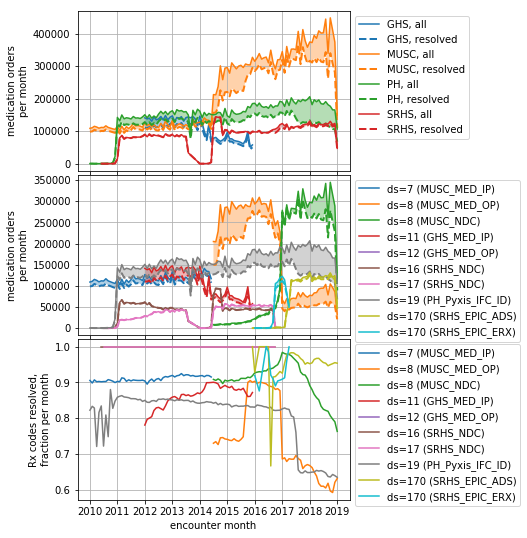

In [31]:
# some orders have future start dates, so let's eliminate those
mo_type_ts = mo_type_ts[mo_type_ts.enc_month<datetime.now()]

# the rest of this cell is plotting logic
fig, axes = plt.subplots(3,1,figsize=(6.5,9), sharex=True, gridspec_kw={'hspace':0.025}) #, sharey=True)

ax = axes[2]
for k,g in mo_type_ts.groupby(cols[:-2]):
    if k[1] != 'HSSC_Common':
        ax.plot(g.enc_month, g.f_resolved, label='ds=%d (%s)'%k)

fbox = ax.get_position()
ax.set_position([fbox.x0, fbox.y0, 0.75*fbox.width, fbox.height])
ax.legend(loc='best', bbox_to_anchor=(1, 1))
ax.grid()
ax.set_xlabel('encounter month')
ax.set_ylabel('Rx codes resolved,\nfraction per month')

ax = axes[1]
for k,g in mo_type_ts.groupby(cols[:-2]):
    if k[1] != 'HSSC_Common':
        bl, = ax.plot(g.enc_month, g.n_all, label='ds=%d (%s)'%k)
        thiscolor = bl.get_color()
        ax.plot(g.enc_month, g.n_resolved, label='_ds=%d (%s), resolved'%k, color=thiscolor, linestyle='--', linewidth=2)
        ax.fill_between(g.enc_month.values, g.n_all, g.n_resolved, facecolor=thiscolor, alpha=0.35)

fbox = ax.get_position()
ax.set_position([fbox.x0, fbox.y0, 0.75*fbox.width, fbox.height])
ax.legend(loc='best', bbox_to_anchor=(1, 1))
ax.grid()
# ax.set_xlabel('encounter month')
ax.set_ylabel('medication orders\nper month')

ax = axes[0]
for k,g in mo_type_ts[mo_type_ts.rx_type_src!='HSSC_Common'].groupby(['inst','enc_month'], as_index=False).agg({'n_all':pd.np.sum, 'n_resolved':pd.np.sum}).groupby('inst'):
    bl, = ax.plot(g.enc_month, g.n_all, label='%s, all'%k)
    thiscolor = bl.get_color()
    ax.plot(g.enc_month, g.n_resolved, label='%s, resolved'%k, color=thiscolor, linestyle='--', linewidth=2)
    ax.fill_between(g.enc_month.values, g.n_all, g.n_resolved, facecolor=thiscolor, alpha=0.35)

fbox = ax.get_position()
ax.set_position([fbox.x0, fbox.y0, 0.75*fbox.width, fbox.height])
# ax.set_ylim(top=379999)
ax.legend(loc='best', bbox_to_anchor=(1, 1))
ax.grid()
# ax.set_xlabel('admission date')
ax.set_ylabel('medication orders\nper month')

# fig.set_tight_layout(True)

# fig.savefig('mo_rx_resolved_by_enc_date_20190123.png', bbox_inches='tight')

In [51]:
fig.set_tight_layout(True)
fig.savefig('mo_rx_resolved_by_enc_date_20190123.png', bbox_inches='tight')

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [52]:
import datetime
datetime.datetime.now()

datetime.datetime(2019, 1, 23, 11, 29, 12, 467569)

The above plots show the number of med orders per month for each institution (top) and each datasource/code_system (middle).  Solid lines are the total number of orders; dashed lines are the number of orders with resolved codes.  So, the swaths of color filling the region between solid and dashed lines correspond to the number of unresolved codes (i.e., large areas of color = bad).

In the bottom graph, the yellow (SRHS_EPIC_ERX) and green (MUSC_NDC) dashed lines at zero reflect the issue of Jira BUGS-22 (Subj: "Unresolved med codes (SRHS, MUSC)").

... so let's address those bugs.

## Resolve PH NDC codes

In [33]:
is_ph = (mo_df.rx_type_src == 'PH_Pyxis_IFC_ID')
mo_df_ph_agg = mo_df[is_ph].groupby(['rx_src', 'rx_tgt'])[['n']].sum().reset_index()

In [34]:
print(len(mo_df_ph_agg))
mo_df_ph_agg.head()

3504


rx_src  rx_tgt    n
0  20065  221017    4
1  20069  705610  240
2  20070  141963    2
3  20247  308891   12
4  20851   53616    2

In [35]:
sql_ph_ndc = '''
select src_code, src_desc, ndc_code, rxcui
from cdwref.ref_medcode
where src_code_type = 'PH_Pyxis_IFC_ID'
group by src_code, src_desc, ndc_code, rxcui
'''

df_ph_ndc = pd.DataFrame(list(q(sql_ph_ndc)), columns=['src_code', 'src_desc', 'ndc_code', 'rxcui'])
df_ph_ndc_mos = mo_df_ph_agg.merge(df_ph_ndc, how='right', left_on='rx_src', right_on='src_code')
df_ph_ndc_mos.sort_values('n', ascending=False).head()

0.175:	connect
2.052:	execute
2.184:	first batch
2.185:	total


rx_src   rx_tgt         n src_code  \
1735  27299  1740467  637048.0    27299   
1215  25209  1049221  348479.0    25209   
1559  26593   209387  344454.0    26593   
34    21035  1807639  290751.0    21035   
1226  25264   992460  284817.0    25264   

                                               src_desc       ndc_code  \
1735                 2 ML Ondansetron 2 MG/ML Injection  63323-0373-02   
1215  Acetaminophen 325 MG / Oxycodone Hydrochloride...  68308-0405-47   
1559         Acetaminophen 325 MG Oral Tablet [Tylenol]  50580-0501-50   
34            1000 ML Sodium Chloride 9 MG/ML Injection  00338-0049-04   
1226  1 ML Promethazine Hydrochloride 25 MG/ML Injec...  39822-5500-03   

        rxcui  
1735  1740467  
1215  1049221  
1559   209387  
34    1807639  
1226   992460

In [36]:
len(df_ph_ndc_mos)

5241

In [37]:
df = df_ph_ndc_mos
%time ndc2rxcui_ph = {ndc:get_rxcui_from_ndc(ndc) for ndc in df.ndc_code.str[0:13]}
# pickle.dump(rxnorm_req.cache, open('rxnorm_req.cache.pickle', 'wb'))

CPU times: user 1min 33s, sys: 3.1 s, total: 1min 36s
Wall time: 14min 11s


In [38]:
pickle.dump(rxnorm_req.cache, open('rxnorm_req.cache.pickle', 'wb'))

In [39]:
df_ndc2rxcui_ph = pd.DataFrame.from_dict(ndc2rxcui_ph, orient='index', dtype=str)
df_ndc2rxcui_ph = df_ndc2rxcui_ph.reset_index()
df_ndc2rxcui_ph.columns = ['src_code', 'rxcui']
df_ndc2rxcui_ph.head()

src_code   rxcui
0  00173-0664-00    None
1  65162-0664-90  705610
2  59762-3140-01  141963
3  00121-0766-16  308891
4  00409-4170-01    None

In [40]:
%time df_ndc2rxcui_ph = df_ndc2rxcui_ph.merge(df_ndc2rxcui_ph.rxcui.apply(get_props_df), how='left', left_index=True, right_index=True)

CPU times: user 6.59 s, sys: 210 ms, total: 6.8 s
Wall time: 45.7 s


In [41]:
df_ndc2rxcui_ph = df_ndc2rxcui_ph.applymap(lambda x: pd.np.NaN if x is None or x=='None' else x)

In [42]:
df_ndc2rxcui_ph.rxtty.fillna('N/A').value_counts()

N/A     1608
SCD     1322
SBD      886
BPCK       7
GPCK       1
Name: rxtty, dtype: int64

In [43]:
df_ph_ndc_mos['ndc13'] = df_ph_ndc_mos.ndc_code.str[0:13]

In [44]:
df_ph_ndc_mos = df_ph_ndc_mos.merge(df_ndc2rxcui_ph, left_on='ndc13', right_on='src_code')

In [45]:
df_ph_ndc_mos.head()

rx_src  rx_tgt      n src_code_x                               src_desc  \
0  20065  221017    4.0      20065                                   None   
1  20069  705610  240.0      20069      Ranitidine 15 MG/ML Oral Solution   
2  20070  141963    2.0      20070  Azithromycin 40 MG/ML Oral Suspension   
3  27282  141963  936.0      27282  Azithromycin 40 MG/ML Oral Suspension   
4  31263  141963  118.0      31263  Azithromycin 40 MG/ML Oral Suspension   

        ndc_code   rxcui          ndc13     src_code_y rxcui_x  \
0  00173-0664-00    None  00173-0664-00  00173-0664-00     NaN   
1  65162-0664-90  705610  65162-0664-90  65162-0664-90  705610   
2  59762-3140-01  141963  59762-3140-01  59762-3140-01  141963   
3  59762-3140-01  141963  59762-3140-01  59762-3140-01  141963   
4  59762-3140-01  141963  59762-3140-01  59762-3140-01  141963   

                                  rxname rxcui_y  \
0                                    NaN     NaN   
1      Ranitidine 15 MG/ML Oral Solution  705610   
2  Azithromycin 40 MG/ML Oral Suspension  141963   
3  Azithromycin 40 MG/ML Oral Suspension  141963   
4  Azithromycin 40 MG/ML Oral Suspension  141963   

                                          rxsyn rxtty mo_code  
0                                           NaN   NaN     NaN  
1               ranitidine 75 MG per 5 ML Syrup   SCD  705610  
2  azithromycin 200 MG per 5 ML Oral Suspension   SCD  141963  
3  azithromycin 200 MG per 5 ML Oral Suspension   SCD  141963  
4  azithromycin 200 MG per 5 ML Oral Suspension   SCD  141963

In [46]:
df_ph_ndc_mos[df_ph_ndc_mos.n>0].fillna('N/A').groupby('rxtty').n.sum()
# df_ph_ndc_mos.groupby('rxtty').n.sum()

rxtty
BPCK       1390.0
GPCK        198.0
N/A     2744731.0
SBD     2193199.0
SCD     7799322.0
Name: n, dtype: float64

In [47]:
len(df_ph_ndc_mos), len(df_ph_ndc)

(5241, 5241)

In [72]:
df_ph_ndc.head()

src_code src_desc        ndc_code    rxcui
0    23759     None   00169-1837-11  1372723
1    32147     None  51079-0992-20a    42687
2    30006     None   00409-1638-02   262138
3    24562     None   51672-1289-02     7597
4    32530     None  51927-1377-25l   151317

In [48]:
df_ph_ndc.head()

src_code                                src_desc       ndc_code   rxcui
0    26441                                    None  00083-0019-76    None
1    21002                                    None  00074-7923-37    None
2    21058  100 ML Metronidazole 5 MG/ML Injection  00409-7811-37  311683
3    21061    50 ML Gentamicin 1.6 MG/ML Injection  00338-0509-41  310477
4    21064                                    None  00173-0441-00    None

In [56]:
get_rxcui_from_ndc('00083-0019-76')

In [73]:
df_ph_ndc_mos.head()

rx_src  rx_tgt      n src_code_x src_desc        ndc_code   rxcui  \
0  20065  221017    4.0      20065     None   00173-0664-00  221017   
1  20069  203136  225.0      20069     None   65162-0664-90  203136   
2  20070   18631    2.0      20070     None   59762-3140-01   18631   
3  27282   18631  873.0      27282     None   59762-3140-01   18631   
4  31263  196474  108.0      31263     None  59762-3140-01a  196474   

           ndc13     src_code_y rxcui_x mo_code rxcui_y  \
0  00173-0664-00  00173-0664-00     NaN     NaN     NaN   
1  65162-0664-90  65162-0664-90  705610  705610  705610   
2  59762-3140-01  59762-3140-01  141963  141963  141963   
3  59762-3140-01  59762-3140-01  141963  141963  141963   
4  59762-3140-01  59762-3140-01  141963  141963  141963   

                                  rxname  \
0                                    NaN   
1      Ranitidine 15 MG/ML Oral Solution   
2  Azithromycin 40 MG/ML Oral Suspension   
3  Azithromycin 40 MG/ML Oral Suspension   
4  Azithromycin 40 MG/ML Oral Suspension   

                                          rxsyn rxtty  
0                                           NaN   NaN  
1               ranitidine 75 MG per 5 ML Syrup   SCD  
2  azithromycin 200 MG per 5 ML Oral Suspension   SCD  
3  azithromycin 200 MG per 5 ML Oral Suspension   SCD  
4  azithromycin 200 MG per 5 ML Oral Suspension   SCD

In [49]:
df_ph_ndc_mos.head()

rx_src  rx_tgt      n src_code_x                               src_desc  \
0  20065  221017    4.0      20065                                   None   
1  20069  705610  240.0      20069      Ranitidine 15 MG/ML Oral Solution   
2  20070  141963    2.0      20070  Azithromycin 40 MG/ML Oral Suspension   
3  27282  141963  936.0      27282  Azithromycin 40 MG/ML Oral Suspension   
4  31263  141963  118.0      31263  Azithromycin 40 MG/ML Oral Suspension   

        ndc_code   rxcui          ndc13     src_code_y rxcui_x  \
0  00173-0664-00    None  00173-0664-00  00173-0664-00     NaN   
1  65162-0664-90  705610  65162-0664-90  65162-0664-90  705610   
2  59762-3140-01  141963  59762-3140-01  59762-3140-01  141963   
3  59762-3140-01  141963  59762-3140-01  59762-3140-01  141963   
4  59762-3140-01  141963  59762-3140-01  59762-3140-01  141963   

                                  rxname rxcui_y  \
0                                    NaN     NaN   
1      Ranitidine 15 MG/ML Oral Solution  705610   
2  Azithromycin 40 MG/ML Oral Suspension  141963   
3  Azithromycin 40 MG/ML Oral Suspension  141963   
4  Azithromycin 40 MG/ML Oral Suspension  141963   

                                          rxsyn rxtty mo_code  
0                                           NaN   NaN     NaN  
1               ranitidine 75 MG per 5 ML Syrup   SCD  705610  
2  azithromycin 200 MG per 5 ML Oral Suspension   SCD  141963  
3  azithromycin 200 MG per 5 ML Oral Suspension   SCD  141963  
4  azithromycin 200 MG per 5 ML Oral Suspension   SCD  141963

In [50]:
pickle.dump(rxnorm_req.cache, open('rxnorm_req.cache.pickle', 'wb'))

In [93]:
df_ph_ndc_mos['n'] = df_ph_ndc_mos.n.fillna(0)
df_ph_ndc_mos.fillna('', inplace=True)

In [94]:
recs_PH_Pyxis_IFC_ID = [('PH', 'PH_Pyxis_IFC_ID', df_rec.src_code_x, df_rec.rxname, df_rec.ndc13, df_rec.rxcui_y, df_rec.rxname)
                 for idx, df_rec in df_ph_ndc_mos.iterrows()]

In [95]:
recs_PH_Pyxis_IFC_ID[0]
# type(recs_PH_Pyxis_IFC_ID[0][3])

('PH', 'PH_Pyxis_IFC_ID', '20065', '', '00173-0664-00', '', '')

This section was copied from a later cell, which related to the previously resolved MUSC NDC and SRHS NDC codes but adapted for the above PH codes.

First, let's backup and remove the existing PH codes in CDWREF.

```
create table ref_medcode_PH_Pyxis_IFC_ID as
select *
from cdwref.ref_medcode
where src_code_type = 'PH_Pyxis_IFC_ID'
;

delete from cdwref.ref_medcode where src_code_type = 'PH_Pyxis_IFC_ID';

commit;
```

Now, we'll insert...

In [99]:
stmt_prpd = '''
insert into
cdwref.ref_medcode
  (institution, src_code_type, src_code, src_desc,
   ndc_code, rxcui, rxnorm_desc, last_updated)
values
(:1, :2, :3, :4, :5, :6, :7, sysdate)
'''

t0 = time.time()
t1_conn = t2_prep = t3_exec = t4_cmmt = t5_f = t0-1

conn = cx_Oracle.connect('%s/%s@%s:1521/%s'%(DB_USR,
                                             DB_PWD,
                                             DB_SVR,
                                             DB_SID))
try:
    crsr = conn.cursor()
    t1_conn = time.time()
    crsr.prepare(stmt_prpd)
    t2_prep = time.time()
    crsr.executemany(None, recs_PH_Pyxis_IFC_ID)  # recs_SRHS_EPIC_ERX + recs_MUSC_NDC)
    t3_exec = time.time()
    conn.commit()
    t4_cmmt = time.time()
except cx_Oracle.DatabaseError as e:
    conn.rollback()
    error, = e.args
    print(error.code)
    print(error.message)
    print(error.context)
finally:
    t5_f = time.time()
    crsr.close()
    conn.close()
    print('%.3f:\tconnect\n%.3f:\tprepare\n%.3f:\texecute\n%.3f:\tcommit\n%.3f:\ttotal'%(t1_conn-t0,t2_prep-t0,t3_exec-t0,t4_cmmt-t0,t5_f-t0))


0.443:	connect
0.443:	prepare
2.918:	execute
2.975:	commit
2.975:	total


Based on new CDWREF code mappings for PH, correct medication order codes in CDW:
```
merge into cdw.medication_order mo
using (select src_code_type, src_code, rxcui from cdwref.ref_medcode
       where src_code_type = 'PH_Pyxis_IFC_ID' ) ref_mc
    on ( mo.med_code_type_orig = ref_mc.src_code_type
        and mo.med_code_orig = ref_mc.src_code )
when matched
then update set
    med_code = ref_mc.rxcui,
    med_code_type = 'RXNORM'
where med_code_type_orig = 'PH_Pyxis_IFC_ID'
;
```

## Resolve MUSC_NDC codes

In [9]:
is_musc_ndc = (mo_df.rx_type_src == 'MUSC_NDC')
freq(mo_df[is_musc_ndc], 'resolved')

COUNT   PERC  CUMPERC
resolved                        
False     371589  100.0    100.0

In [10]:
mo_df[is_musc_ndc].head().T

27                   76                   78   \
mo_ds                          8                    8                    8   
rx_src              49281-399-65         10135-220-01         42291-146-50   
rx_type_src             MUSC_NDC             MUSC_NDC             MUSC_NDC   
rx_tgt                       NaN                  NaN                  NaN   
rx_type_tgt                  NaN                  NaN                  NaN   
enc_date     2016-09-21 00:00:00  2016-09-26 00:00:00  2017-01-29 00:00:00   
n                              3                    4                   13   
enc_month    2016-09-01 00:00:00  2016-09-01 00:00:00  2017-01-01 00:00:00   
resolved                   False                False                False   
recent                     False                False                 True   

                             106                  125  
mo_ds                          8                    8  
rx_src              35356-355-30         42291-266-01  
rx_type_src             MUSC_NDC             MUSC_NDC  
rx_tgt                       NaN                  NaN  
rx_type_tgt                  NaN                  NaN  
enc_date     2015-12-30 00:00:00  2015-10-23 00:00:00  
n                              1                    2  
enc_month    2015-12-01 00:00:00  2015-10-01 00:00:00  
resolved                   False                False  
recent                     False                False

In [11]:
print(len(mo_df[is_musc_ndc]), len(mo_df[is_musc_ndc].rx_src.drop_duplicates()))

371589 7137


In [12]:
%time ndc2rxcui = {ndc:get_rxcui_from_ndc(ndc) for ndc in mo_df[is_musc_ndc].rx_src.drop_duplicates()}
# pickle.dump(rxnorm_req.cache, open('rxnorm_req.cache.pickle', 'wb'))

CPU times: user 89.5 ms, sys: 38 µs, total: 89.6 ms
Wall time: 88.3 ms


In [13]:
df_ndc2rxcui = pd.DataFrame.from_dict(ndc2rxcui, orient='index', dtype=str)
df_ndc2rxcui = df_ndc2rxcui.reset_index()
df_ndc2rxcui.columns = ['src_code', 'rxcui']
df_ndc2rxcui.head()

src_code    rxcui
0  49281-399-65  1801183
1  10135-220-01   237735
2  42291-146-50   259255
3  35356-355-30   197444
4  42291-266-01  1367410

In [14]:
def get_scd(rxcui):
#     rxnorm_req.cache = {}
    
    json = rxnorm_req('rxcui/%s/related'%rxcui, tty='SCD') #, rela='has_ingredients')
    try:
        retval = [conceptGroup['conceptProperties'] for conceptGroup in
                   json['relatedGroup']['conceptGroup']]
        retval = [item for sublist in retval for item in sublist]
        retval = [(rec['tty'], rec['rxcui'], rec['name']) for rec in retval]
    except KeyError as e:
        #warning('missing key %s'%e)
        return []
    return retval

get_scd('1242786')

[('SCD',
  '312033',
  'Ethinyl Estradiol 0.035 MG / Norethindrone 1 MG Oral Tablet'),
 ('SCD', '748797', 'Inert Ingredients 1 MG Oral Tablet')]

In [15]:
%time df_ndc2rxcui = df_ndc2rxcui.merge(df_ndc2rxcui.rxcui.apply(get_props_df), how='left', left_index=True, right_index=True)

CPU times: user 1.41 s, sys: 4.04 ms, total: 1.41 s
Wall time: 1.41 s


In [16]:
df_ndc2rxcui[df_ndc2rxcui.rxtty=='BPCK'].head()

src_code  rxcui_x  mo_code  rxcui_y  \
497   68462-394-29  1242786  1242786  1242786   
649   0093-3134-82  1149667  1149667  1149667   
680   51862-279-01  1359032  1359032  1359032   
1094  35356-255-28   748856   748856   748856   
1203  54868-4754-0   753482   753482   753482   

                                                 rxname  \
497   {21 (Ethinyl Estradiol 0.035 MG / Norethindron...   
649   {7 (Ethinyl Estradiol 0.01 MG Oral Tablet) / 8...   
680   {21 (Ethinyl Estradiol 0.03 MG / norethindrone...   
1094  {24 (drospirenone 3 MG / Ethinyl Estradiol 0.0...   
1203  {21 (Desogestrel 0.15 MG / Ethinyl Estradiol 0...   

                               rxsyn rxtty  
497          Alyacen 1/35 28-Day Kit  BPCK  
649              Camrese 91 Day Pack  BPCK  
680   Microgestin 1.5/30 21 Day Pack  BPCK  
1094                 Yaz 28 Day Pack  BPCK  
1203                Apri 28 Day Pack  BPCK

In [17]:
df_ndc2rxcui.rxtty.value_counts()

SCD     3137
SBD     1769
BPCK     157
GPCK      42
Name: rxtty, dtype: int64

## Resolve SRHS ERX codes

In [18]:
is_srhs_erx = (mo_df.rx_type_src == 'SRHS_EPIC_ERX')
freq(mo_df[is_srhs_erx], 'resolved')

COUNT   PERC  CUMPERC
resolved                        
False     120519  100.0    100.0

In [19]:
mo_df[is_srhs_erx].head().T

107                  131                  133  \
mo_ds                        170                  170                  170   
rx_src                     11500               400291                33512   
rx_type_src        SRHS_EPIC_ERX        SRHS_EPIC_ERX        SRHS_EPIC_ERX   
rx_tgt                       NaN                  NaN                  NaN   
rx_type_tgt                  NaN                  NaN                  NaN   
enc_date     2017-01-25 00:00:00  2017-02-11 00:00:00  2016-11-16 00:00:00   
n                              1                  103                   15   
enc_month    2017-01-01 00:00:00  2017-02-01 00:00:00  2016-11-01 00:00:00   
resolved                   False                False                False   
recent                      True                 True                 True   

                             135                  153  
mo_ds                        170                  170  
rx_src                     33175                31310  
rx_type_src        SRHS_EPIC_ERX        SRHS_EPIC_ERX  
rx_tgt                       NaN                  NaN  
rx_type_tgt                  NaN                  NaN  
enc_date     2017-03-29 00:00:00  2017-04-06 00:00:00  
n                              8                    5  
enc_month    2017-03-01 00:00:00  2017-04-01 00:00:00  
resolved                   False                False  
recent                      True                 True

In [20]:
ads2ndc = pd.read_excel('SRHS_ADS_ERX_System List_20170609.xlsx', dtype=str)

In [21]:
%time ndc2rxcui2 = {ndc:get_rxcui_from_ndc(ndc) for ndc in ads2ndc.NDC.drop_duplicates().values}
# pickle.dump(rxnorm_req.cache, open('rxnorm_req.cache.pickle', 'wb'))

CPU times: user 16 ms, sys: 97 µs, total: 16.1 ms
Wall time: 15.4 ms


In [27]:
df_ndc2rxcui2 = pd.DataFrame.from_dict(ndc2rxcui2, orient='index', dtype=str)
df_ndc2rxcui2.columns=['rxcui']

df_ndc2rxcui2 = df_ndc2rxcui2.merge(df_ndc2rxcui2.rxcui.apply(get_props_df), how='left', left_index=True, right_index=True)

In [28]:
ads2ndc = ads2ndc.merge(df_ndc2rxcui2, how='left', left_on='NDC', right_index=True)

In [29]:
ads2ndc[ads2ndc.ADS!='nan'].head().T

5   \
ADS                                                 05181 [ERX]   
Medication                       ABACAVIR 300 MG TABLET [24438]   
NDC Group                                                   nan   
NDC                                                65862-073-60   
Implied Unit                                           1 tablet   
Unit to Use                              Package Unit [Default]   
Package Unit                                               each   
Form                                                     tablet   
rxcui                                                    242679   
src_code                                                  05181   
rxcui_x                                                  242679   
mo_code                                                  242679   
rxcui_y                                                  242679   
rxname                              abacavir 300 MG Oral Tablet   
rxsyn         abacavir (as abacavir sulfate) 300 MG Oral Tablet   
rxtty                                                       SCD   

                                                             6   \
ADS                                                 08195 [ERX]   
Medication    ABACAVIR 600 MG-DOLUTEGRAVIR 50 MG-LAMIVUDINE ...   
NDC Group                                                   nan   
NDC                                                49702-231-13   
Implied Unit                                           1 tablet   
Unit to Use                              Package Unit [Default]   
Package Unit                                               each   
Form                                                     tablet   
rxcui                                                   1546894   
src_code                                                  08195   
rxcui_x                                                 1546894   
mo_code                                                 1546894   
rxcui_y                                                 1546894   
rxname        abacavir 600 MG / dolutegravir 50 MG / Lamivud...   
rxsyn         abacavir 600 MG / dolutegravir 50 MG / 3TC 300...   
rxtty                                                       SBD   

                                                             7   \
ADS                                                 06794 [ERX]   
Medication    ABATACEPT (WITH MALTOSE) 250 MG INTRAVENOUS SO...   
NDC Group                                                   nan   
NDC                                                0003-2187-10   
Implied Unit                                              10 mL   
Unit to Use                              Package Unit [Default]   
Package Unit                                               each   
Form                                                 recon soln   
rxcui                                                    616018   
src_code                                                  06794   
rxcui_x                                                  616018   
mo_code                                                  616018   
rxcui_y                                                  616018   
rxname                     abatacept 250 MG Injection [Orencia]   
rxsyn                                  Orencia 250 MG Injection   
rxtty                                                       SBD   

                                                             9   \
ADS                                                 02028 [NDG]   
Medication    ABCIXIMAB 10 MG/5 ML INTRAVENOUS SOLUTION [14369]   
NDC Group                                            5 mL Vial    
NDC                                                0002-7140-01   
Implied Unit                                               5 mL   
Unit to Use                            Entire Package [Default]   
Package Unit                                                 mL   
Form                                                   solution   
rxcui                                 

In [30]:
ads2ndc['src_code'] = ads2ndc.ADS.str[:-6].apply(lambda x: x if len(x)>0 else None)

In [31]:
ads2ndc[~ads2ndc.src_code.isnull()]

ADS                                         Medication  \
5     05181 [ERX]                     ABACAVIR 300 MG TABLET [24438]   
6     08195 [ERX]  ABACAVIR 600 MG-DOLUTEGRAVIR 50 MG-LAMIVUDINE ...   
7     06794 [ERX]  ABATACEPT (WITH MALTOSE) 250 MG INTRAVENOUS SO...   
9     02028 [NDG]  ABCIXIMAB 10 MG/5 ML INTRAVENOUS SOLUTION [14369]   
11    06476 [ERX]  ACAMPROSATE 333 MG TABLET,DELAYED RELEASE [39720]   
12    08002 [ERX]                      ACARBOSE 25 MG TABLET [22148]   
13    08002 [ERX]                      ACARBOSE 25 MG TABLET [22148]   
14    03058 [ERX]                      ACARBOSE 50 MG TABLET [15895]   
15    03058 [ERX]                      ACARBOSE 50 MG TABLET [15895]   
16    00093 [ERX]                   ACEBUTOLOL 200 MG CAPSULE [8939]   
17    00093 [ERX]                   ACEBUTOLOL 200 MG CAPSULE [8939]   
18    07662 [NDG]  ACETAMINOPHEN 1,000 MG/100 ML (10 MG/ML) INTRA...   
19    02569 [ERX]      ACETAMINOPHEN 120 MG RECTAL SUPPOSITORY [103]   
20    02569 [ERX]      ACETAMINOPHEN 120 MG RECTAL SUPPOSITORY [103]   
21    02569 [ERX]      ACETAMINOPHEN 120 MG RECTAL SUPPOSITORY [103]   
22    02079 [NDG]  ACETAMINOPHEN 120 MG-CODEINE 12 MG/5 ML (5 ML)...   
23    02079 [NDG]  ACETAMINOPHEN 120 MG-CODEINE 12 MG/5 ML (5 ML)...   
24    01474 [NDG]  ACETAMINOPHEN 160 MG/5 ML (5 ML) ORAL SOLUTION...   
25    03117 [ERX]  ACETAMINOPHEN 300 MG-CODEINE 30 MG TABLET [14087]   
26    03117 [ERX]  ACETAMINOPHEN 300 MG-CODEINE 30 MG TABLET [14087]   
27    02565 [ERX]      ACETAMINOPHEN 325 MG RECTAL SUPPOSITORY [104]   
28    02565 [ERX]      ACETAMINOPHEN 325 MG RECTAL SUPPOSITORY [104]   
29    02565 [ERX]      ACETAMINOPHEN 325 MG RECTAL SUPPOSITORY [104]   
30    03800 [ERX]                  ACETAMINOPHEN 325 MG TABLET [101]   
31    03800 [ERX]                  ACETAMINOPHEN 325 MG TABLET [101]   
32    03800 [ERX]                  ACETAMINOPHEN 325 MG TABLET [101]   
33    06467 [ERX]                  ACETAMINOPHEN 500 MG TABLET [102]   
34    06467 [ERX]                  ACETAMINOPHEN 500 MG TABLET [102]   
35    06467 [ERX]                  ACETAMINOPHEN 500 MG TABLET [102]   
36    02578 [ERX]      ACETAMINOPHEN 650 MG RECTAL SUPPOSITORY [105]   
...           ...                                                ...   
6200  01547 [ERX]         ZINC SULFATE 220 MG (50 MG) CAPSULE [8880]   
6201  06768 [NDG]   ZINC SULFATE 5 MG/ML INTRAVENOUS SOLUTION [8879]   
6202  06768 [NDG]   ZINC SULFATE 5 MG/ML INTRAVENOUS SOLUTION [8879]   
6203  05576 [ERX]                  ZIPRASIDONE 20 MG CAPSULE [29778]   
6204  05576 [ERX]                  ZIPRASIDONE 20 MG CAPSULE [29778]   
6205  05576 [ERX]                  ZIPRASIDONE 20 MG CAPSULE [29778]   
6206  05983 [ERX]  ZIPRASIDONE 20 MG/ML (FINAL CONCENTRATION) INT...   
6207  05915 [ERX]                  ZIPRASIDONE 80 MG CAPSULE [29781]   
6208  05915 [ERX]                  ZIPRASIDONE 80 MG CAPSULE [29781]   
6209  07823 [NDG]  ZIV-AFLIBERCEPT 100 MG/4 ML (25 MG/ML) INTRAVE...   
6210  07824 [NDG]  ZIV-AFLIBERCEPT 200 MG/8 ML (25 MG/ML) INTRAVE...   
6212  05763 [NDG]  ZOLEDRONIC ACID 4 MG/5 ML INTRAVENOUS SOLUTION...   
6213  05763 [NDG]  ZOLEDRONIC ACID 4 MG/5 ML INTRAVENOUS SOLUTION...   
6214  05763 [NDG]  ZOLEDRONIC ACID 4 MG/5 ML INTRAVENOUS SOLUTION...   
6215  05763 [NDG]  ZOLEDRONIC ACID 4 MG/5 ML INTRAVENOUS SOLUTION...   
6216  06970 [NDG]  ZOLEDRONIC ACID 5 MG/100 ML IN MANNITOL 5 %-WA...   
6218  04594 [ERX]                 ZOLMITRIPTAN 2.5 MG TABLET [21588]   
6219  04594 [ERX]                 ZOLMITRIPTAN 2.5 MG TABLET [21588]   
6220  04594 [ERX]                 ZOLMITRIPTAN 2.5 MG TABLET [21588]   
6221  03113 [ERX]                       ZOLPIDEM 5 MG TABLET [11701]   
6222  03113 [ERX]                       ZOLPIDEM 5 MG TABLET [11701]   
6223  03113 [ERX]                       ZOLPIDEM 5 MG TABLET [11701]   
6224  06881 [ERX]  ZOLPIDEM ER 12.5 MG TABLET,EXTENDED RELEASE,MU...   
6225  06897 [ERX]  ZOLPIDEM ER 6.25 MG TABLET,EXTENDED

## Add codes for CDWREF

Let's see if we can get the MUSC_NDC code descriptions from the HTB-to-CDW staging tables.

In [42]:
sql = '''
select rx_code, rx_name, count(1)
from cdw.med_order_staging
where rx_code_cs = 'MUSC_NDC'
group by rx_code, rx_name
order by count(1) desc
'''

%time df_musc_ndc_src = pd.DataFrame(list(q(sql)), columns=['src_code', 'src_desc', 'n'])

df_ndc2rxcui = df_ndc2rxcui.merge(df_musc_ndc_src, how='left', on='src_code')
df_ndc2rxcui.head().T

1.151:	connect
1045.839:	execute
1047.074:	first batch
1047.076:	total
CPU times: user 145 ms, sys: 45.6 ms, total: 190 ms
Wall time: 17min 27s


In [66]:
recs_SRHS_EPIC_ERX = [('SRHS', 'SRHS_EPIC_ERX', df_rec.src_code, df_rec.Medication, df_rec.NDC, df_rec.rxcui, df_rec.rxname)
                      for idx, df_rec in ads2ndc[~ads2ndc.src_code.isnull()].iterrows()]
recs_MUSC_NDC = [('MUSC', 'MUSC_NDC', df_rec.src_code, df_rec.src_desc, df_rec.src_code, df_rec.mo_code, df_rec.rxname)
                 for idx, df_rec in df_ndc2rxcui.iterrows()]

In [68]:
stmt_prpd = '''
insert into
cdwref.ref_medcode
  (institution, src_code_type, src_code, src_desc,
   ndc_code, rxcui, rxnorm_desc, last_updated)
values
(:1, :2, :3, :4, :5, :6, :7, sysdate)
'''

t0 = time.time()
t1_conn = t2_prep = t3_exec = t4_cmmt = t5_f = t0-1

conn = cx_Oracle.connect('%s/%s@%s:1521/%s'%(DB_USR,
                                             DB_PWD,
                                             DB_SVR,
                                             DB_SID))
try:
    crsr = conn.cursor()
    t1_conn = time.time()
    crsr.prepare(stmt_prpd)
    t2_prep = time.time()
    crsr.executemany(None, recs_SRHS_EPIC_ERX + recs_MUSC_NDC)
    t3_exec = time.time()
    conn.commit()
    t4_cmmt = time.time()
except cx_Oracle.DatabaseError as e:
    conn.rollback()
    error, = e.args
    print(error.code)
    print(error.message)
    print(error.context)
finally:
    t5_f = time.time()
    crsr.close()
    conn.close()
    print('%.3f:\tconnect\n%.3f:\tprepare\n%.3f:\texecute\n%.3f:\tcommit\n%.3f:\ttotal'%(t1_conn-t0,t2_prep-t0,t3_exec-t0,t4_cmmt-t0,t5_f-t0))


1.038:	connect
1.038:	prepare
22.516:	execute
24.370:	commit
24.370:	total


## Update medication orders

After inserting records into CDWREF, as above, I realized that one SRHS_EPIC_ERX code has multiple NDC codes, so I cleaned up the *duplicate* mappings as follows:
```
delete from cdwref.ref_medcode
where rowid in (
    select rowid from
    (
        select
            rowid,
            rank() over
                (partition by src_code_type, src_code
                 order by rxcui NULLS LAST, rowid) as rnk
        from cdwref.ref_medcode
        where src_code_type = 'SRHS_EPIC_ERX'
    )
    where rnk > 1
)
;
```

I, also, just noticed that the SRHS_EPIC_ERX med_code values in the data correspond to the bracketed code in the `Medication` field of the above DataFrame and *not* to the ADS code, which was inserted into CDWREF.  Accordinngly, I'll update those records and store the ADS code in the `NOTES` column, which was not yet used for these records:
```
update cdwref.ref_medcode
set
    notes = 'ADS=' || src_code,
    src_code = trim(trailing ']' from
                 trim(leading '[' from
                   substr(src_desc, instr(src_desc, '['))
                 )
               )
where src_code_type = 'SRHS_EPIC_ERX'
;
```

While the update of CDWREF.REF_MEDCODE leads to the automatic mapping of med codes of incoming med orders to RXCUI, the already existing med orders must be updated separately.  So, here, I'll update the med orders for SRHS_EPIC_ERX and MUSC_NDC.
```
merge into cdw.medication_order mo
using (select src_code_type, src_code, rxcui from cdwref.ref_medcode
       where src_code_type in ('MUSC_NDC', 'SRHS_EPIC_ERX') ) ref_mc
    on ( mo.med_code_type_orig = ref_mc.src_code_type
        and mo.med_code_orig = ref_mc.src_code )
when matched
then update set
    med_code = ref_mc.rxcui,
    med_code_type = 'RXNORM'
where med_code is null
  and med_code_type_orig in ('MUSC_NDC', 'SRHS_EPIC_ERX')
;
```

## Resolve historical exceptions
### In particular, start with SRHS_NDC

In [36]:
is_srhs_ndc = (mo_df.rx_type_src == 'SRHS_NDC')
freq(mo_df[is_srhs_ndc], ['enc_month','resolved'], agglvl=1).head()

enc_month  resolved  COUNT       PERC     CUMPERC
1 2010-06-01      True     47  85.454545   85.454545
0 2010-06-01     False      8  14.545455  100.000000
3 2010-07-01      True     91  94.791667   94.791667
2 2010-07-01     False      5   5.208333  100.000000
5 2010-08-01      True     34  77.272727   77.272727

In [30]:
%time ndc2rxcui3 = {ndc:get_rxcui_from_ndc(ndc) for ndc in mo_df[is_srhs_ndc&(mo_df.rx_tgt.isnull())].rx_src.drop_duplicates()}
pickle.dump(rxnorm_req.cache, open('rxnorm_req.cache.pickle', 'wb'))

CPU times: user 3min 20s, sys: 6.01 s, total: 3min 26s
Wall time: 15min 48s


In [31]:
df_ndc2rxcui3 = pd.DataFrame.from_dict(ndc2rxcui3, orient='index', dtype=str)
df_ndc2rxcui3 = df_ndc2rxcui3.reset_index()
df_ndc2rxcui3.columns = ['src_code', 'rxcui']
df_ndc2rxcui3.head()

src_code   rxcui
0  38396061563    None
1  00000000577    None
2  10135017362  308416
3  00000000062    None
4  00574704512  312104

In [48]:
sql = '''
select rx_code, rx_name, count(1)
from cdw.med_order_staging
where rx_code_cs = 'SRHS_NDC'
group by rx_code, rx_name
order by count(1) desc
'''

%time df_srhs_ndc_src = pd.DataFrame(list(q(sql)), columns=['src_code', 'src_desc', 'n'])

df_ndc2rxcui3 = df_ndc2rxcui3.merge(df_srhs_ndc_src, how='left', on='src_code')
df_ndc2rxcui3.head().T

0.275:	connect
43.992:	execute
44.093:	first batch
44.093:	total
CPU times: user 36.5 ms, sys: 24.5 ms, total: 60.9 ms
Wall time: 44.1 s


0                            1  \
src_code  38396061563                  00000000577   
rxcui_x          None                         None   
mo_code          None                         None   
rxcui_y          None                         None   
rxname           None                         None   
rxsyn            None                         None   
rxtty            None                         None   
src_desc          NaN  A GREEN HOSPITALIST TEAM EA   
n                 NaN                          760   

                                                  2  \
src_code                                10135017362   
rxcui_x                                      308416   
mo_code                                      308416   
rxcui_y                                      308416   
rxname    Aspirin 81 MG Delayed Release Oral Tablet   
rxsyn         ASA 81 MG Delayed Release Oral Tablet   
rxtty                                           SCD   
src_desc                                        NaN   
n                                               NaN   

                                  3  \
src_code                00000000062   
rxcui_x                        None   
mo_code                        None   
rxcui_y                        None   
rxname                         None   
rxsyn                          None   
rxtty                          None   
src_desc  LAXATIVE OF CHOICE UNITS?   
n                              2583   

                                                          4  
src_code                                        00574704512  
rxcui_x                                              312104  
mo_code                                              312104  
rxcui_y                                              312104  
rxname    Belladonna Alkaloids 16.2 MG / Opium 30 MG Rec...  
rxsyn                                                        
rxtty                                                   SCD  
src_desc                           B & O 15A (USE FOR) SUPP  
n                                                        28

In [46]:
%time df_ndc2rxcui3 = df_ndc2rxcui3.merge(df_ndc2rxcui3.rxcui.apply(get_props_df), how='left', left_index=True, right_index=True)

CPU times: user 8.95 s, sys: 164 ms, total: 9.11 s
Wall time: 41 s


In [50]:
pickle.dump(rxnorm_req.cache, open('rxnorm_req.cache.pickle', 'wb'))

In [61]:
recs_SRHS_NDC = [('SRHS', 'SRHS_NDC', df_rec.src_code, df_rec.src_desc, df_rec.src_code, df_rec.mo_code, df_rec.rxname)
                 for idx, df_rec in df_ndc2rxcui3.fillna('').iterrows()]

In [62]:
stmt_prpd = '''
insert into
cdwref.ref_medcode
  (institution, src_code_type, src_code, src_desc,
   ndc_code, rxcui, rxnorm_desc, last_updated)
values
(:1, :2, :3, :4, :5, :6, :7, sysdate)
'''

t0 = time.time()
t1_conn = t2_prep = t3_exec = t4_cmmt = t5_f = t0-1

conn = cx_Oracle.connect('%s/%s@%s:1521/%s'%(DB_USR,
                                             DB_PWD,
                                             DB_SVR,
                                             DB_SID))
try:
    crsr = conn.cursor()
    t1_conn = time.time()
    crsr.prepare(stmt_prpd)
    t2_prep = time.time()
    crsr.executemany(None, recs_SRHS_NDC)
    t3_exec = time.time()
    conn.commit()
    t4_cmmt = time.time()
except (cx_Oracle.DatabaseError, TypeError) as e:
    print('ERROR... Rolling back changes!')
    conn.rollback()
    error, = e.args
    print(error)
#     print(error.code)
#     print(error.message)
#     print(error.context)
finally:
    t5_f = time.time()
    crsr.close()
    conn.close()
    print('%.3f:\tconnect\n%.3f:\tprepare\n%.3f:\texecute\n%.3f:\tcommit\n%.3f:\ttotal'%(t1_conn-t0,t2_prep-t0,t3_exec-t0,t4_cmmt-t0,t5_f-t0))


0.878:	connect
0.879:	prepare
1.517:	execute
1.529:	commit
1.529:	total


... and execute `merge` statement similar to the previous one (above) for SRHS_NDC:
```
merge into cdw.medication_order mo
using (select src_code_type, src_code, rxcui from cdwref.ref_medcode
       where src_code_type in ('SRHS_NDC')
         and rxcui is NOT NULL) ref_mc
    on ( mo.med_code_type_orig = ref_mc.src_code_type
        and mo.med_code_orig = ref_mc.src_code )
when matched
then update set
    med_code = ref_mc.rxcui,
    med_code_type = 'RXNORM'
where med_code is null
  and med_code_type_orig in ('SRHS_NDC')
;
```

# All RXCUIs

In [97]:
%%time
# sed '1d' mo_df.csv | awk -F',' '{print $4}' | sort | uniq > rxcuis_uniq.txt
# egrep "^[0-9]+$" rxcuis_uniq.txt > rxcuis_uniq2.txt
# mv rxcuis_uniq2.txt rxcuis_uniq.txt

rxcuis = {}
with open('rxcuis_uniq.txt', 'r') as fin:
    for line in fin:
        k = line[:-1]
        rxcuis[k] = get_props(k)
# pickle.dump(rxnorm_req.cache, open('rxnorm_req.cache.pickle', 'wb'))

CPU times: user 30.5 ms, sys: 0 ns, total: 30.5 ms
Wall time: 38.7 ms


In [98]:
tty_hist = Counter([props['tty'] if props is not None else 'Unresolved' for rxcui, props in rxcuis.items()])
pprint(tty_hist)

Counter({'SCD': 3064,
         'SBD': 2197,
         'IN': 1187,
         'BN': 764,
         'PIN': 438,
         'Unresolved': 283,
         'MIN': 214,
         'BPCK': 163,
         'GPCK': 39,
         'SCDG': 32,
         'SCDF': 17,
         'SBDG': 12,
         'SCDC': 2,
         'SBDC': 1,
         'DF': 1,
         'SBDF': 1})


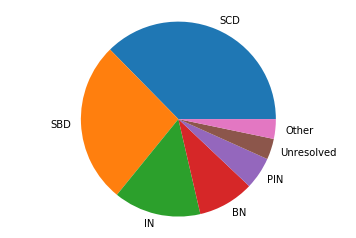

In [99]:
def norm_counter(cntr):
    s = sum(list(cntr.values()))
    return {k:v/s for (k,v) in cntr.items()}

def group_low_freq(cntr, ngroups=7):
    cntr_nrmd = norm_counter(cntr)
    srtd = sorted(cntr.items(), key=lambda x:x[1], reverse=True)
    grpd = {k:v for (k,v) in srtd[0:ngroups-1]}
    grpd['Other'] = sum([v for k,v in srtd[ngroups:]])
    return grpd

tty_hist_grpd = group_low_freq(tty_hist)
tty_pie = plt.pie(list(tty_hist_grpd.values()), labels=list(tty_hist_grpd.keys()))
plt.axis('equal')
plt.savefig('tty_pie.png')

In [100]:
mo_df['inst'] = mo_df.mo_ds.map(ds2inst)
mo_df.inst.value_counts()

MUSC    3120743
SRHS    1654656
PH      1634431
GHS      827655
Name: inst, dtype: int64

In [101]:
df_inst_tgt = mo_df[mo_df.enc_month>=datetime(2010, 1,1)].groupby(['inst', 'rx_tgt']).n.agg([sum]).reset_index()
# df_inst_tgt = mo_df.groupby(['inst', 'rx_tgt']).n.agg([sum]).reset_index()

In [102]:
cnames = list(rxcuis['1000001'].keys())
for rxcui,props in rxcuis.items():
    if props is None:
        rxcuis[rxcui] = {k:None for k in cnames}
        rxcuis[rxcui]['rxcui'] = rxcui
        rxcuis[rxcui]['tty'] = 'Unresolved'

In [103]:
df_rxcuis = pd.DataFrame.from_dict(rxcuis, orient='index')
# df_inst_tgt.merge()

In [104]:
df_rxcuis[df_rxcuis.rxcui=='1000480']

rxcui  name synonym         tty language suppress umlscui
1000480  1000480  None    None  Unresolved     None     None    None

In [105]:
%time df_rxcuis['status'] = df_rxcuis.rxcui.apply(get_status)
# pickle.dump(rxnorm_req.cache, open('rxnorm_req.cache.pickle', 'wb'))

CPU times: user 34.2 ms, sys: 0 ns, total: 34.2 ms
Wall time: 43.9 ms


In [106]:
# print(df_inst_tgt.head())
# print(df_rxcuis.head())
df_inst_rxnorm = df_inst_tgt.merge(df_rxcuis, how='left', left_on='rx_tgt', right_on='rxcui')

In [107]:
df_inst_rxnorm.head().T

0           1  \
inst                              GHS         GHS   
rx_tgt                        1000112     1000480   
sum                              1579          82   
rxcui                         1000112     1000480   
name      medroxyprogesterone acetate        None   
synonym                                      None   
tty                               PIN  Unresolved   
language                          ENG        None   
suppress                            N        None   
umlscui                      C0065864        None   
status                         Active     Retired   

                                                         2  \
inst                                                   GHS   
rx_tgt                                             1007348   
sum                                                     26   
rxcui                                              1007348   
name      Estrogens, Esterified (USP) / Methyltestosterone   
synonym                                                      
tty                                                    MIN   
language                                               ENG   
suppress                                                 N   
umlscui                                           C2928270   
status                                              Active   

                                             3  \
inst                                       GHS   
rx_tgt                                 1008145   
sum                                        431   
rxcui                                  1008145   
name      emtricitabine / tenofovir disoproxil   
synonym                                          
tty                                        MIN   
language                                   ENG   
suppress                                     N   
umlscui                               C2929052   
status                                  Active   

                                                          4  
inst                                                    GHS  
rx_tgt                                              1008309  
sum                                                      68  
rxcui                                               1008309  
name      Mineral Oil / Petrolatum / Phenylephrine / Sha...  
synonym                                                      
tty                                                     MIN  
language                                                ENG  
suppress                                                  N  
umlscui                                            C2929216  
status                                               Active

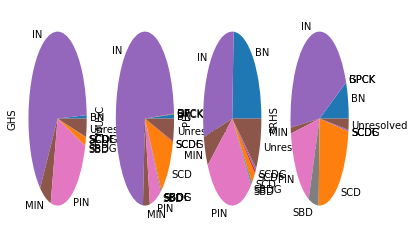

In [108]:
df_inst_rxnorm_T = df_inst_rxnorm[['inst', 'tty', 'sum']].groupby(['inst', 'tty']).agg([sum]).unstack()['sum']['sum'].T
df_inst_rxnorm_T.fillna(0, inplace=True)
df_inst_rxnorm_T.plot.pie(subplots=True, legend=False)
inst_rxnorm_cntrs = {}
for inst in df_inst_rxnorm.inst.unique():
    s_inst_rxnorm = df_inst_rxnorm_T.loc[:,inst]
    inst_rxnorm_cntrs[inst] = {k:v for (k,v) in zip(s_inst_rxnorm.index.values, s_inst_rxnorm.values)}

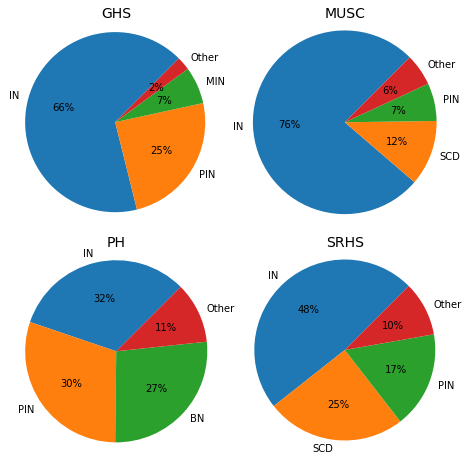

In [109]:
fig, _ = plt.subplots(2,2, figsize=(6.5,6.5))
axes = fig.get_axes()
for ax, (inst,cntr) in zip(axes,inst_rxnorm_cntrs.items()):
    tty_hist_grpd = group_low_freq(cntr, 4)
    tty_pie = ax.pie(list(tty_hist_grpd.values()), labels=list(tty_hist_grpd.keys()),
                     autopct='%1.0f%%', startangle=45)
    ax.axis('equal')
    ax.set_title(inst, fontsize=14)
plt.tight_layout()
# plt.savefig('tty_by_inst_gt2017.png')

In [110]:
df_rxcuis.head().T

1000001  \
rxcui                                               1000001   
name      Amlodipine 5 MG / Hydrochlorothiazide 25 MG / ...   
synonym   Amlodipine 5 MG / HCTZ 25 MG / Olmesartan medo...   
tty                                                     SCD   
language                                                ENG   
suppress                                                  N   
umlscui                                            C2930061   
status                                               Active   

                                                    1000005  \
rxcui                                               1000005   
name      Amlodipine 5 MG / Hydrochlorothiazide 25 MG / ...   
synonym   Amlodipine 5 MG / HCTZ 25 MG / Olmesartan medo...   
tty                                                     SBD   
language                                                ENG   
suppress                                                  N   
umlscui                                            C2930065   
status                                               Active   

                                           1000048  \
rxcui                                      1000048   
name      Doxepin Hydrochloride 10 MG Oral Capsule   
synonym                                              
tty                                            SCD   
language                                       ENG   
suppress                                         N   
umlscui                                   C0688670   
status                                      Active   

                                                    1000054  \
rxcui                                               1000054   
name           Doxepin Hydrochloride 10 MG/ML Oral Solution   
synonym   doxepin hydrochloride 10 MG per 1 ML Concentra...   
tty                                                     SCD   
language                                                ENG   
suppress                                                  N   
umlscui                                            C0976539   
status                                               Active   

                                            1000058  
rxcui                                       1000058  
name      Doxepin Hydrochloride 100 MG Oral Capsule  
synonym                                              
tty                                             SCD  
language                                        ENG  
suppress                                          N  
umlscui                                    C0688672  
status                                       Active

## Compare to SHRINE ontology

In [111]:
cols_preps, cols_rxterms = get_cols('medications_prep_2_1.csv', ','), get_cols('medications_rxterms_2_1.csv', ',')
cols_match = cols_preps==cols_rxterms
df_ont = load_files(['medications_prep_2_1.csv', 'medications_rxterms_2_1.csv'],
                    delims=',', quotechar='"', escapechar='"', quoting=0) if cols_match else None
if df_ont is None:
    print('df is empty!  Maybe the columns don\'t match')

In [112]:
df_ont['rxcui'] = df_ont.C_BASECODE.str[4:]
df_ont_rxcui = df_ont.groupby('rxcui')[['C_HLEVEL']].agg('count').reset_index()
df_ont_rxcui.columns = ['rxcui', 'n_ont_nodes']

In [113]:
cols_grpby = ['rxcui', 'name', 'synonym', 'tty', 'status']
cols_rx = ['mo_code', 'rxname', 'rxsyn', 'rxtty']
df_data = df_inst_rxnorm.groupby(cols_grpby)[['sum']].agg('sum').reset_index()

In [114]:
df_ont_or_data = df_ont_rxcui.merge(df_data, how='outer', on='rxcui')

In [115]:
df_ont_or_data.columns = ['n_orders' if cname=='sum' else cname for cname in df_ont_or_data.columns]
df_ont_or_data['n_orders'] = df_ont_or_data.n_orders.fillna(0)
df_ont_or_data['n_ont_nodes'] = df_ont_or_data.n_ont_nodes.fillna(0)

In [116]:
df_ont_or_data.head().T
# sum(df_ont_or_data.rxcui.isnull())

0                                                  1  \
rxcui        1000000                                            1000001   
n_ont_nodes        3                                                  3   
name             NaN  Amlodipine 5 MG / Hydrochlorothiazide 25 MG / ...   
synonym          NaN  Amlodipine 5 MG / HCTZ 25 MG / Olmesartan medo...   
tty              NaN                                                SCD   
status           NaN                                             Active   
n_orders           0                                                 13   

                                                             2        3  \
rxcui                                                  1000005  1000009   
n_ont_nodes                                                  3        3   
name         Amlodipine 5 MG / Hydrochlorothiazide 25 MG / ...      NaN   
synonym      Amlodipine 5 MG / HCTZ 25 MG / Olmesartan medo...      NaN   
tty                                                        SBD      NaN   
status                                                  Active      NaN   
n_orders                                                     3        0   

                   4  
rxcui        1000013  
n_ont_nodes        1  
name             NaN  
synonym          NaN  
tty              NaN  
status           NaN  
n_orders           0

In [117]:
df_ont_or_data.loc[:,cols_grpby[:-1]] = df_ont_or_data.rxcui.apply(get_props_df).loc[:,cols_rx].values

In [118]:
df_ont_or_data.head().T
# sum(df_ont_or_data.rxcui.isnull())

0  \
rxcui                                                  1000000   
n_ont_nodes                                                  3   
name         Amlodipine 5 MG / Hydrochlorothiazide 12.5 MG ...   
synonym      Amlodipine 5 MG / HCTZ 12.5 MG / Olmesartan me...   
tty                                                        SBD   
status                                                     NaN   
n_orders                                                     0   

                                                             1  \
rxcui                                                  1000001   
n_ont_nodes                                                  3   
name         Amlodipine 5 MG / Hydrochlorothiazide 25 MG / ...   
synonym      Amlodipine 5 MG / HCTZ 25 MG / Olmesartan medo...   
tty                                                        SCD   
status                                                  Active   
n_orders                                                    13   

                                                             2  \
rxcui                                                  1000005   
n_ont_nodes                                                  3   
name         Amlodipine 5 MG / Hydrochlorothiazide 25 MG / ...   
synonym      Amlodipine 5 MG / HCTZ 25 MG / Olmesartan medo...   
tty                                                        SBD   
status                                                  Active   
n_orders                                                     3   

                                                             3  \
rxcui                                                  1000009   
n_ont_nodes                                                  3   
name         dimethicone 100 MG/ML / Miconazole Nitrate 20 ...   
synonym      dimethicone 10 % / miconazole nitrate 2 % / zi...   
tty                                                        SCD   
status                                                     NaN   
n_orders                                                     0   

                                                             4  
rxcui                                                  1000013  
n_ont_nodes                                                  1  
name         whole wheat allergenic extract 50 MG/ML Inject...  
synonym      whole wheat allergenic extract 0.05 GM/ML Inje...  
tty                                                        SCD  
status                                                     NaN  
n_orders                                                     0

In [119]:
is_d_not_o = df_ont_or_data.n_ont_nodes==0
is_o_not_d = df_ont_or_data.n_orders==0
is_d_and_o = ~(is_d_not_o | is_o_not_d)

n_codes_in_ont = sum(df_ont_or_data.n_ont_nodes>0)
n_codes_in_data = sum(df_ont_or_data.n_orders>0)
n_orders = df_ont_or_data.n_orders.sum()

n_order_codes_accessible = sum(is_d_and_o)
n_order_codes_inaccessible = sum(is_d_not_o)
if n_order_codes_accessible+n_order_codes_inaccessible != n_codes_in_data:
    print('SOMETHING IS WRONG!')

n_orders_accessible = df_ont_or_data.n_orders[is_d_and_o].sum()
n_orders_inaccessible = df_ont_or_data.n_orders[is_d_not_o].sum()

print(n_orders, n_orders_inaccessible, n_orders_accessible)
print(n_orders_accessible/n_orders)
print(n_order_codes_accessible/n_codes_in_data)

32303711.0 10802952.0 21500759.0
0.665581703601
0.724371611631


In [120]:
df_ont_or_data.head()

rxcui  n_ont_nodes                                               name  \
0  1000000          3.0  Amlodipine 5 MG / Hydrochlorothiazide 12.5 MG ...   
1  1000001          3.0  Amlodipine 5 MG / Hydrochlorothiazide 25 MG / ...   
2  1000005          3.0  Amlodipine 5 MG / Hydrochlorothiazide 25 MG / ...   
3  1000009          3.0  dimethicone 100 MG/ML / Miconazole Nitrate 20 ...   
4  1000013          1.0  whole wheat allergenic extract 50 MG/ML Inject...   

                                             synonym  tty  status  n_orders  
0  Amlodipine 5 MG / HCTZ 12.5 MG / Olmesartan me...  SBD     NaN       0.0  
1  Amlodipine 5 MG / HCTZ 25 MG / Olmesartan medo...  SCD  Active      13.0  
2  Amlodipine 5 MG / HCTZ 25 MG / Olmesartan medo...  SBD  Active       3.0  
3  dimethicone 10 % / miconazole nitrate 2 % / zi...  SCD     NaN       0.0  
4  whole wheat allergenic extract 0.05 GM/ML Inje...  SCD     NaN       0.0

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd557918358>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fd557b175f8>], dtype=object)

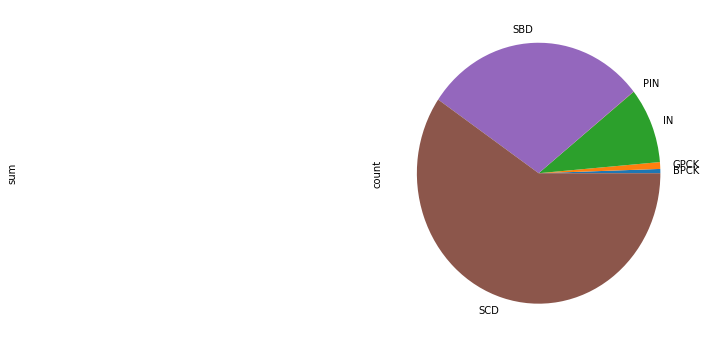

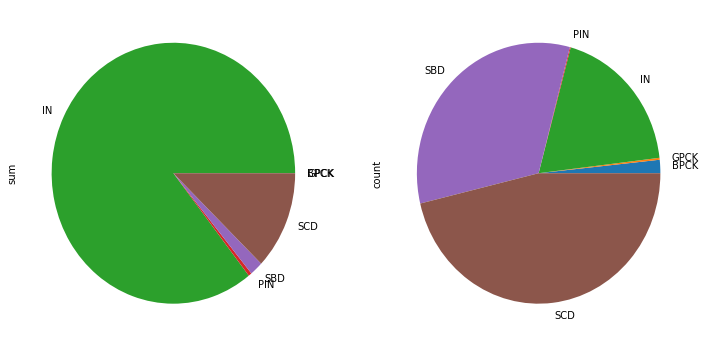

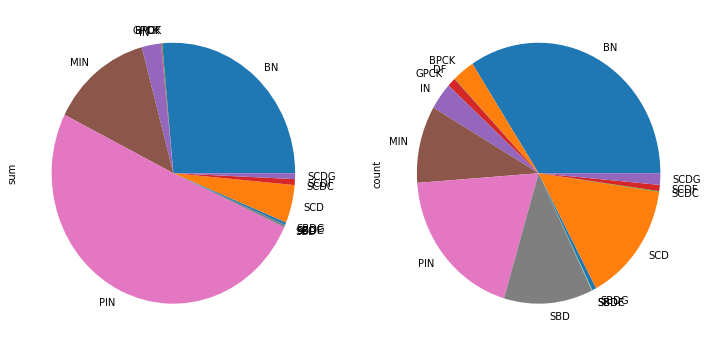

In [121]:
df_ont_or_data[is_o_not_d].groupby(['tty']).n_orders.agg(['sum', 'count']).plot.pie(subplots=True, figsize=(12,6), legend=False)
df_ont_or_data[is_d_and_o].groupby(['tty']).n_orders.agg(['sum', 'count']).plot.pie(subplots=True, figsize=(12,6), legend=False)
df_ont_or_data[is_d_not_o].groupby(['tty']).n_orders.agg(['sum', 'count']).plot.pie(subplots=True, figsize=(12,6), legend=False)

In [122]:
pin2in = df_ont_or_data[(df_ont_or_data.tty=='PIN')&is_d_not_o].rxcui.apply(get_ins)
bn2in = df_ont_or_data[(df_ont_or_data.tty=='BN')&is_d_not_o].rxcui.apply(get_ins)
scd2in = df_ont_or_data[(df_ont_or_data.tty=='SCD')&is_d_not_o].rxcui.apply(get_ins)
any2in = df_ont_or_data[(df_ont_or_data.tty!='IN')&(is_d_not_o|is_d_and_o)].rxcui.apply(get_ins)
pickle.dump(rxnorm_req.cache, open('rxnorm_req.cache.pickle', 'wb'))

In [123]:
# df_ont_or_data['rxcui_in_fallback'] = pd.concat([pin2in[pin2in.apply(len)==1],
#                                                  bn2in[bn2in.apply(len)==1],
#                                                  scd2in[scd2in.apply(len)==1]])
df_ont_or_data['rxcui_in_fallback'] = pd.concat([any2in[any2in.apply(len)==1]])

In [124]:
def rxcui_opt(x):
    if x.n_ont_nodes == 0:
        if isinstance(x.rxcui_in_fallback, list):
            return x.rxcui_in_fallback[0][0]
        return x.rxcui_in_fallback
    else:
        return x.rxcui
    
df_ont_or_data['rxcui_aligned'] = df_ont_or_data.apply(rxcui_opt, axis=1)

In [125]:
df_ont_or_data = df_ont_or_data.applymap(lambda x: pd.np.NaN if x is None else x)

In [126]:
df_ont_or_data = df_ont_or_data.merge(df_ont_rxcui, how='left', left_on='rxcui_aligned', right_on='rxcui', suffixes=('', '_2'))

In [127]:
df_ont_or_data.n_ont_nodes_2.fillna(0, inplace=True)

32303711.0 2395375.0 29908336.0
0.925848302692
0.916584524396


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd55853a5f8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fd558992ba8>], dtype=object)

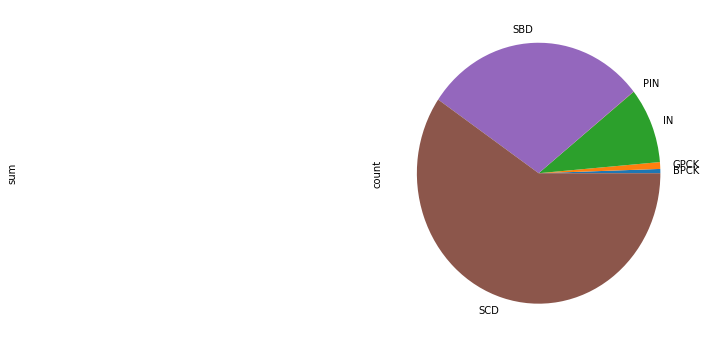

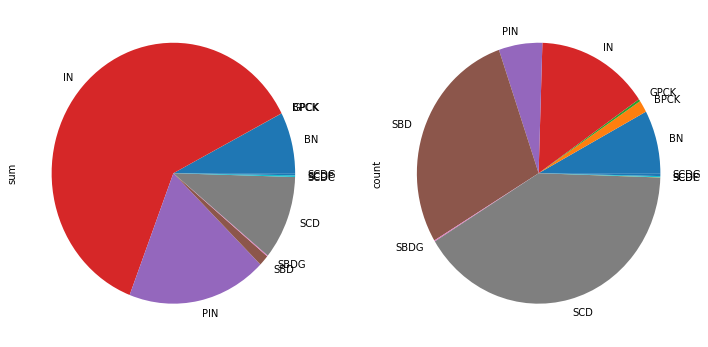

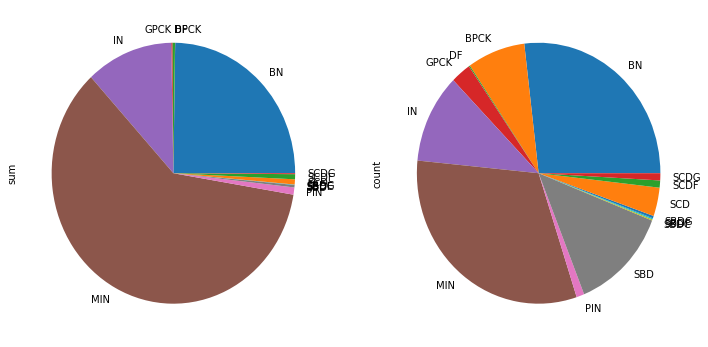

In [128]:
is_d_not_o = df_ont_or_data.n_ont_nodes + df_ont_or_data.n_ont_nodes_2 == 0
is_o_not_d = df_ont_or_data.n_orders==0
is_d_and_o = ~(is_d_not_o | is_o_not_d)

n_codes_in_ont = sum(df_ont_or_data.n_ont_nodes>0)
n_codes_in_data = sum(df_ont_or_data.n_orders>0)
n_orders = df_ont_or_data.n_orders.sum()

n_order_codes_accessible = sum(is_d_and_o)
n_order_codes_inaccessible = sum(is_d_not_o)
if n_order_codes_accessible+n_order_codes_inaccessible != n_codes_in_data:
    print('SOMETHING IS WRONG!')

n_orders_accessible = df_ont_or_data.n_orders[is_d_and_o].sum()
n_orders_inaccessible = df_ont_or_data.n_orders[is_d_not_o].sum()

print(n_orders, n_orders_inaccessible, n_orders_accessible)
print(n_orders_accessible/n_orders)
print(n_order_codes_accessible/n_codes_in_data)

df_ont_or_data[is_o_not_d].groupby(['tty']).n_orders.agg(['sum', 'count']).plot.pie(subplots=True, figsize=(12,6), legend=False)
df_ont_or_data[is_d_and_o].groupby(['tty']).n_orders.agg(['sum', 'count']).plot.pie(subplots=True, figsize=(12,6), legend=False)
df_ont_or_data[is_d_not_o].groupby(['tty']).n_orders.agg(['sum', 'count']).plot.pie(subplots=True, figsize=(12,6), legend=False)

In [138]:
pickle.dump(rxnorm_req.cache, open('rxnorm_req.cache.pickle', 'wb'))

In [135]:
src2tgt_in = pd.concat([df_ont_or_data.loc[is_d_and_o|is_d_not_o,['rxcui', 'name', 'tty']],any2in], axis=1)
src2tgt_in.columns = ['rxcui_orig', 'rxcui_orig_desc', 'rxcui_orig_tty', 'rxcui_ins']
src2tgt_in['rxcui_ins'] = src2tgt_in.rxcui_ins.apply(lambda x: [] if not isinstance(x,list) else x)
src2tgt_in[src2tgt_in.rxcui_ins.str.len()>0].head()

rxcui_orig                                    rxcui_orig_desc  \
1     1000001  Amlodipine 5 MG / Hydrochlorothiazide 25 MG / ...   
2     1000005  Amlodipine 5 MG / Hydrochlorothiazide 25 MG / ...   
13    1000048           Doxepin Hydrochloride 10 MG Oral Capsule   
14    1000054       Doxepin Hydrochloride 10 MG/ML Oral Solution   
15    1000058          Doxepin Hydrochloride 100 MG Oral Capsule   

   rxcui_orig_tty                                          rxcui_ins  
1             SCD  [(5487, Hydrochlorothiazide), (17767, Amlodipi...  
2             SBD  [(5487, Hydrochlorothiazide), (17767, Amlodipi...  
13            SCD                                  [(3638, Doxepin)]  
14            SCD                                  [(3638, Doxepin)]  
15            SCD                                  [(3638, Doxepin)]

In [163]:
recs_cc_tgt2ins = []
for (idx, rec) in src2tgt_in.iterrows():
    rxcui, desc = rec.rxcui_orig, rec.rxcui_orig_desc
    tty, n_ings = rec.rxcui_orig_tty, len(rec.rxcui_ins)
    for ing in rec.rxcui_ins:
        recs_cc_tgt2ins.append((rxcui, desc, tty, n_ings, ing[0], ing[1]))

In [164]:
recs_cc_tgt2ins[0:3]

[('1000001',
  'Amlodipine 5 MG / Hydrochlorothiazide 25 MG / Olmesartan medoxomil 40 MG Oral Tablet',
  'SCD',
  3,
  '5487',
  'Hydrochlorothiazide'),
 ('1000001',
  'Amlodipine 5 MG / Hydrochlorothiazide 25 MG / Olmesartan medoxomil 40 MG Oral Tablet',
  'SCD',
  3,
  '17767',
  'Amlodipine'),
 ('1000001',
  'Amlodipine 5 MG / Hydrochlorothiazide 25 MG / Olmesartan medoxomil 40 MG Oral Tablet',
  'SCD',
  3,
  '321064',
  'olmesartan')]

In [166]:
sql_drop_table = '''
drop table cdwref.ref_rxcui_to_ingrs
'''

sql_create_table = '''
create table cdwref.ref_rxcui_to_ingrs 
( rxcui       varchar2(16) not null,
  rxcui_desc  varchar2(2048) not null,
  tty         varchar2(4) not null,
  n_ingrs     number(2) not null,
  ingr_rxcui  varchar2(16) not null,
  ingr_desc   varchar2(512) not null,
  CONSTRAINT ref_rxcui_to_ingrs_pk UNIQUE (rxcui, ingr_rxcui)
)
'''

stmt_prpd = '''
insert into
cdwref.ref_rxcui_to_ingrs
  (rxcui, rxcui_desc, tty, n_ingrs, ingr_rxcui, ingr_desc)
values
(:1, :2, :3, :4, :5, :6)
'''

t0 = time.time()
t1_conn = t2_prep = t3_exec = t4_cmmt = t5_f = t0-1

conn = cx_Oracle.connect('%s/%s@%s:1521/%s'%(DB_USR,
                                             DB_PWD,
                                             DB_SVR,
                                             DB_SID))
try:
    crsr = conn.cursor()
    crsr.execute(sql_drop_table)
    crsr.execute(sql_create_table)
    t1_conn = time.time()
    crsr.prepare(stmt_prpd)
    t2_prep = time.time()
    crsr.executemany(None, recs_cc_tgt2ins)
    t3_exec = time.time()
    conn.commit()
    t4_cmmt = time.time()
except (cx_Oracle.DatabaseError, TypeError) as e:
    print('ERROR... Rolling back changes!')
    conn.rollback()
    error, = e.args
    print(error)
    raise e
#     print(error.code)
#     print(error.message)
#     print(error.context)
finally:
    t5_f = time.time()
    crsr.close()
    conn.close()
    print('%.3f:\tconnect\n%.3f:\tprepare\n%.3f:\texecute\n%.3f:\tcommit\n%.3f:\ttotal'%(t1_conn-t0,t2_prep-t0,t3_exec-t0,t4_cmmt-t0,t5_f-t0))


0.247:	connect
0.247:	prepare
0.881:	execute
0.916:	commit
0.916:	total


In [169]:
r2i = list(q('select * from cdwref.ref_rxcui_to_ingrs order by rxcui'))

0.139:	connect
0.160:	execute
0.433:	first batch
0.434:	total


In [170]:
r2i

[('1000001',
  'Amlodipine 5 MG / Hydrochlorothiazide 25 MG / Olmesartan medoxomil 40 MG Oral Tablet',
  'SCD',
  3,
  '17767',
  'Amlodipine'),
 ('1000001',
  'Amlodipine 5 MG / Hydrochlorothiazide 25 MG / Olmesartan medoxomil 40 MG Oral Tablet',
  'SCD',
  3,
  '321064',
  'olmesartan'),
 ('1000001',
  'Amlodipine 5 MG / Hydrochlorothiazide 25 MG / Olmesartan medoxomil 40 MG Oral Tablet',
  'SCD',
  3,
  '5487',
  'Hydrochlorothiazide'),
 ('1000005',
  'Amlodipine 5 MG / Hydrochlorothiazide 25 MG / Olmesartan medoxomil 40 MG Oral Tablet [Tribenzor]',
  'SBD',
  3,
  '17767',
  'Amlodipine'),
 ('1000005',
  'Amlodipine 5 MG / Hydrochlorothiazide 25 MG / Olmesartan medoxomil 40 MG Oral Tablet [Tribenzor]',
  'SBD',
  3,
  '321064',
  'olmesartan'),
 ('1000005',
  'Amlodipine 5 MG / Hydrochlorothiazide 25 MG / Olmesartan medoxomil 40 MG Oral Tablet [Tribenzor]',
  'SBD',
  3,
  '5487',
  'Hydrochlorothiazide'),
 ('1000048',
  'Doxepin Hydrochloride 10 MG Oral Capsule',
  'SCD',
  1,
  '

# SCRATCH

In [ ]:
%%time

tty_hist = Counter()
stat_hist = Counter()

with open('hssc_meds_not_in_cc_ont.csv', 'r') as fin, \
     open('hssc_meds_not_in_cc_ont_out.csv', 'w') as fout:
    cnames = ['med_code_in', 'status', 'rxcui', 'tty', 'name']
    cnames_props = ['rxcui', 'tty', 'name']
    writer = csv.DictWriter(fout, fieldnames=cnames)
    writer.writeheader()
    for med_code_in in fin:
        med_code_in = med_code_in.rstrip('\n')
        if med_code_in is None or len(med_code_in)<=0:
            continue
        
        mout = { 'med_code_in': med_code_in }
        status = get_status(med_code_in)
        mout['status'] = status
        stat_hist[status] += 1
        
        if status not in ('Retired', 'Unknown', 'Alien'):
            dont_coerce = (status == 'Active')
            props = get_props(med_code_in, skip_coerce=dont_coerce)
            mout.update({key:props[key] for key in cnames_props})
            tty_hist[mout['tty']] += 1
        
        writer.writerow(mout)
        
pprint(stat_hist)
pprint(tty_hist)

In [ ]:
%%time

# get_ins(161)
# Create separate map to ingredients
with open('hssc_meds_not_in_cc_ont_out.csv', 'r') as fin, \
     open('hssc_meds_not_in_cc_ont_out_ins.csv', 'w') as fout:
    rdr = csv.reader(fin)
    next(rdr, None)
    wtr = csv.writer(fout)
    wtr.writerow(['rxcui', 'in_rxcui', 'in_name'])
    for fields in rdr:
        rxcui, tty = fields[2], fields[3]
        if rxcui is not None and len(rxcui) > 0:
            if tty != 'IN':
                for (in_rxcui, in_name) in get_ins(rxcui):
                    wtr.writerow([rxcui,in_rxcui,in_name])
            else:
                wtr.writerow([rxcui,rxcui,fields[4]])

```
┌─[ephelps@ephelps-M4800:~/Downloads]
└──$ grep Medications ccollabOntology_102.csv \
>  | awk -F',' 'BEGIN{OFS="\t"}{print $7,$NF}' \
>  | tr -d '"' \
>  | sed 's/RXC://' \
>  | sed 's/(RXC:.*)//' \
> > cc_medcodes.tsv
```

In [ ]:
get_ins(7670)

## Resolve GHS NDC codes

In [12]:
is_GHS_IP = (mo_df.rx_type_src == 'GHS_MED_IP')
mo_df_ghs_ip_agg = mo_df[is_GHS_IP].groupby(['rx_src', 'rx_tgt'])[['n']].sum().reset_index()

In [13]:
print(len(mo_df_ghs_ip_agg))
mo_df_ghs_ip_agg.head()

2557


rx_src  rx_tgt    n
0  00002322730  353103   50
1  00002322830  353103   27
2  00002322930  353103  122
3  00002323560  476250  729
4  00002323830  353103   10

In [14]:
sql_ghs_ip_ndc = '''
select src_code, src_desc, rxcui
from cdwref.ref_medcode
where src_code_type = 'GHS_MED_IP'
group by src_code, src_desc, rxcui
'''

df_ghs_ndc = pd.DataFrame(list(q(sql_ghs_ip_ndc)), columns=['src_code', 'src_desc', 'rxcui'])
df_ghs_ndc_mos = mo_df_ghs_ip_agg.merge(df_ghs_ndc, how='right', left_on='rx_src', right_on='src_code')
df_ghs_ndc_mos.sort_values('n', ascending=False).head()

0.115:	connect
0.381:	execute
0.638:	first batch
1.099:	total


rx_src  rx_tgt         n     src_code                   src_desc  \
1799  50580050130     161  115997.0  50580050130                       None   
988   00409475503  203148   99628.0  00409475503                       None   
2486  68084035401    7804   84812.0  68084035401  OXYCODONE HCL 5 MG TABLET   
791   00338004904    9863   83802.0  00338004904                       None   
2284  63323026201    9877   80176.0  63323026201                       None   

       rxcui  
1799     161  
988   203148  
2486    7804  
791     9863  
2284    9877

In [15]:
len(df_ghs_ndc_mos)

130704

In [28]:
def resolve_batch(ndc_lst, n_to_proc=1000, i0=0):
    i1 = min([i0+n_to_proc, i0+len(ndc_lst[i0:])])
#     print('***',i1, i0,len(ndc_lst[i0:]))
    return {ndc:get_rxcui_from_ndc(ndc) for ndc in ndc_lst[i0:i1]}

ndc2rxcui_ghs = {}
i0, n_to_proc = 0, 10000
while i0 < len(df_ghs_ndc_mos.src_code):
    ndc2rxcui_ghs.update(resolve_batch(df_ghs_ndc_mos.src_code, n_to_proc, i0))
    print(i0,len(ndc2rxcui_ghs), len(rxnorm_req.cache))
    i0 = i0 + n_to_proc

0 10000 169308
10000 20000 169308
20000 30000 169308
30000 40000 169308
40000 50000 169308
50000 60000 169308
60000 70000 169308
70000 80000 169308
80000 90000 169308
90000 100000 176471
100000 110000 186291


KeyboardInterrupt: 

130704

In [29]:
# df = df_ghs_ndc_mos
# %time ndc2rxcui_ghs = {ndc:get_rxcui_from_ndc(ndc) for ndc in df.src_code}
pickle.dump(rxnorm_req.cache, open('rxnorm_req.cache.pickle', 'wb'))

In [18]:
df_ndc2rxcui_ghs = pd.DataFrame.from_dict(ndc2rxcui_ghs, orient='index', dtype=str)
df_ndc2rxcui_ghs = df_ndc2rxcui_ph.reset_index()
df_ndc2rxcui_ghs.columns = ['src_code', 'rxcui']
df_ndc2rxcui_ghs.head()

NameError: name 'ndc2rxcui_ghs' is not defined

In [ ]:
%time df_ndc2rxcui_ghs = df_ndc2rxcui_ghs.merge(df_ndc2rxcui_ghs.rxcui.apply(get_props_df), how='left', left_index=True, right_index=True)
pickle.dump(rxnorm_req.cache, open('rxnorm_req.cache.pickle', 'wb'))

In [63]:
df_ndc2rxcui_ph = df_ndc2rxcui_ph.applymap(lambda x: pd.np.NaN if x is None or x=='None' else x)

In [64]:
df_ndc2rxcui_ph.rxtty.fillna('N/A').value_counts()

N/A     1455
SCD     1399
SBD      962
BPCK       7
GPCK       1
Name: rxtty, dtype: int64

In [65]:
df_ph_ndc_mos['ndc13'] = df_ph_ndc_mos.ndc_code.str[0:13]

In [66]:
df_ph_ndc_mos = df_ph_ndc_mos.merge(df_ndc2rxcui_ph, left_on='ndc13', right_on='src_code')

In [68]:
df_ph_ndc_mos.head()

rx_src  rx_tgt      n src_code_x src_desc        ndc_code   rxcui  \
0  20065  221017    4.0      20065     None   00173-0664-00  221017   
1  20069  203136  225.0      20069     None   65162-0664-90  203136   
2  20070   18631    2.0      20070     None   59762-3140-01   18631   
3  27282   18631  873.0      27282     None   59762-3140-01   18631   
4  31263  196474  108.0      31263     None  59762-3140-01a  196474   

           ndc13     src_code_y rxcui_x mo_code rxcui_y  \
0  00173-0664-00  00173-0664-00     NaN     NaN     NaN   
1  65162-0664-90  65162-0664-90  705610  705610  705610   
2  59762-3140-01  59762-3140-01  141963  141963  141963   
3  59762-3140-01  59762-3140-01  141963  141963  141963   
4  59762-3140-01  59762-3140-01  141963  141963  141963   

                                  rxname  \
0                                    NaN   
1      Ranitidine 15 MG/ML Oral Solution   
2  Azithromycin 40 MG/ML Oral Suspension   
3  Azithromycin 40 MG/ML Oral Suspension   
4  Azithromycin 40 MG/ML Oral Suspension   

                                          rxsyn rxtty  
0                                           NaN   NaN  
1               ranitidine 75 MG per 5 ML Syrup   SCD  
2  azithromycin 200 MG per 5 ML Oral Suspension   SCD  
3  azithromycin 200 MG per 5 ML Oral Suspension   SCD  
4  azithromycin 200 MG per 5 ML Oral Suspension   SCD

In [70]:
df_ph_ndc_mos[df_ph_ndc_mos.n>0].fillna('N/A').groupby('rxtty').n.sum()
# df_ph_ndc_mos.groupby('rxtty').n.sum()

rxtty
BPCK        638.0
N/A     2085003.0
SBD     1705010.0
SCD     5863863.0
Name: n, dtype: float64

In [71]:
len(df_ph_ndc_mos), len(df_ph_ndc)

(5241, 5241)

In [72]:
df_ph_ndc.head()

src_code src_desc        ndc_code    rxcui
0    23759     None   00169-1837-11  1372723
1    32147     None  51079-0992-20a    42687
2    30006     None   00409-1638-02   262138
3    24562     None   51672-1289-02     7597
4    32530     None  51927-1377-25l   151317

In [73]:
df_ph_ndc_mos.head()

rx_src  rx_tgt      n src_code_x src_desc        ndc_code   rxcui  \
0  20065  221017    4.0      20065     None   00173-0664-00  221017   
1  20069  203136  225.0      20069     None   65162-0664-90  203136   
2  20070   18631    2.0      20070     None   59762-3140-01   18631   
3  27282   18631  873.0      27282     None   59762-3140-01   18631   
4  31263  196474  108.0      31263     None  59762-3140-01a  196474   

           ndc13     src_code_y rxcui_x mo_code rxcui_y  \
0  00173-0664-00  00173-0664-00     NaN     NaN     NaN   
1  65162-0664-90  65162-0664-90  705610  705610  705610   
2  59762-3140-01  59762-3140-01  141963  141963  141963   
3  59762-3140-01  59762-3140-01  141963  141963  141963   
4  59762-3140-01  59762-3140-01  141963  141963  141963   

                                  rxname  \
0                                    NaN   
1      Ranitidine 15 MG/ML Oral Solution   
2  Azithromycin 40 MG/ML Oral Suspension   
3  Azithromycin 40 MG/ML Oral Suspension   
4  Azithromycin 40 MG/ML Oral Suspension   

                                          rxsyn rxtty  
0                                           NaN   NaN  
1               ranitidine 75 MG per 5 ML Syrup   SCD  
2  azithromycin 200 MG per 5 ML Oral Suspension   SCD  
3  azithromycin 200 MG per 5 ML Oral Suspension   SCD  
4  azithromycin 200 MG per 5 ML Oral Suspension   SCD

In [74]:
pickle.dump(rxnorm_req.cache, open('rxnorm_req.cache.pickle', 'wb'))

In [93]:
df_ph_ndc_mos['n'] = df_ph_ndc_mos.n.fillna(0)
df_ph_ndc_mos.fillna('', inplace=True)

In [94]:
recs_PH_Pyxis_IFC_ID = [('PH', 'PH_Pyxis_IFC_ID', df_rec.src_code_x, df_rec.rxname, df_rec.ndc13, df_rec.rxcui_y, df_rec.rxname)
                 for idx, df_rec in df_ph_ndc_mos.iterrows()]

In [95]:
recs_PH_Pyxis_IFC_ID[0]
# type(recs_PH_Pyxis_IFC_ID[0][3])

('PH', 'PH_Pyxis_IFC_ID', '20065', '', '00173-0664-00', '', '')

This section was copied from a later cell, which related to the previously resolved MUSC NDC and SRHS NDC codes but adapted for the above PH codes.

First, let's backup and remove the existing PH codes in CDWREF.

```
create table ref_medcode_PH_Pyxis_IFC_ID as
select *
from cdwref.ref_medcode
where src_code_type = 'PH_Pyxis_IFC_ID'
;

delete from cdwref.ref_medcode where src_code_type = 'PH_Pyxis_IFC_ID';

commit;
```

Now, we'll insert...

In [99]:
stmt_prpd = '''
insert into
cdwref.ref_medcode
  (institution, src_code_type, src_code, src_desc,
   ndc_code, rxcui, rxnorm_desc, last_updated)
values
(:1, :2, :3, :4, :5, :6, :7, sysdate)
'''

t0 = time.time()
t1_conn = t2_prep = t3_exec = t4_cmmt = t5_f = t0-1

conn = cx_Oracle.connect('%s/%s@%s:1521/%s'%(DB_USR,
                                             DB_PWD,
                                             DB_SVR,
                                             DB_SID))
try:
    crsr = conn.cursor()
    t1_conn = time.time()
    crsr.prepare(stmt_prpd)
    t2_prep = time.time()
    crsr.executemany(None, recs_PH_Pyxis_IFC_ID)  # recs_SRHS_EPIC_ERX + recs_MUSC_NDC)
    t3_exec = time.time()
    conn.commit()
    t4_cmmt = time.time()
except cx_Oracle.DatabaseError as e:
    conn.rollback()
    error, = e.args
    print(error.code)
    print(error.message)
    print(error.context)
finally:
    t5_f = time.time()
    crsr.close()
    conn.close()
    print('%.3f:\tconnect\n%.3f:\tprepare\n%.3f:\texecute\n%.3f:\tcommit\n%.3f:\ttotal'%(t1_conn-t0,t2_prep-t0,t3_exec-t0,t4_cmmt-t0,t5_f-t0))


0.443:	connect
0.443:	prepare
2.918:	execute
2.975:	commit
2.975:	total


Based on new CDWREF code mappings for PH, correct medication order codes in CDW:
```
merge into cdw.medication_order mo
using (select src_code_type, src_code, rxcui from cdwref.ref_medcode
       where src_code_type = 'PH_Pyxis_IFC_ID' ) ref_mc
    on ( mo.med_code_type_orig = ref_mc.src_code_type
        and mo.med_code_orig = ref_mc.src_code )
when matched
then update set
    med_code = ref_mc.rxcui,
    med_code_type = 'RXNORM'
where med_code_type_orig = 'PH_Pyxis_IFC_ID'
;
```